**Predicting which customers will purchase a quoted insurance plan**

**1. Reading data from the given CSV files that is stored in Google Drive.**

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

ModuleNotFoundError: No module named 'google.colab'

---



**2. Load train data from csv file.**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from datetime import datetime

dataPath = '/gdrive/MyDrive/PGD Assignment Notebooks/train.csv'
df = pd.read_csv(dataPath)
print("Total no. of records in train dataset is: {0}".format(df['QuoteNumber'].count()))
#df.rename(columns={'GeographicField64' : 'State', 'Field7' : 'BMI', 'Field12' : 'Is_Smoker', 'PropertyField37': 'IS_Urban', 'Field10' : 'Premium_Amount', 'PersonalField11': 'Family_Size', 'PropertyField14' :'Property_Type'}, inplace = True)

df

Total no. of records in train dataset is: 260753


QuoteNumber Original_Quote_Date  ...  GeographicField63 GeographicField64
0                 1          2013-08-16  ...                  N                CA
1                 2          2014-04-22  ...                  N                NJ
2                 4          2014-08-25  ...                  N                NJ
3                 6          2013-04-15  ...                  N                TX
4                 8          2014-01-25  ...                  N                IL
...             ...                 ...  ...                ...               ...
260748       434584          2013-05-16  ...                  N                TX
260749       434585          2014-12-07  ...                  N                TX
260750       434586          2014-02-18  ...                  N                NJ
260751       434587          2014-04-08  ...                  N                NJ
260752       434588          2013-03-19  ...                  N                NJ

[260753 rows x 299 columns]

***Observation:*** Based on the existing feature names, renamed some of the features for better understanding of the feature.

---



**3. Let's split the "Original_Quote_Date" feature into Year, Month and Is_Weekend to add more features to the existing train dataset.**

---



In [3]:
str_date = df['Original_Quote_Date']
year_lst=[]
month_lst=[]
weekend_lst=[]
date_lst=[]

for i in str_date:
  year_lst.append(int(i[0:4]))
  month_lst.append(int(i[5:7]))
  date_lst.append(int(i[8:]))
  d = datetime(int(i[0:4]), int(i[5:7]), int(i[8:]))
  if d.weekday() > 4:
    weekend_lst.append(1)
  else:
    weekend_lst.append(0)

df['Year'] = year_lst
df['Month'] = month_lst
df['Is_Weekend'] = weekend_lst

df.drop(['Original_Quote_Date'], axis = 1, inplace = True)

df

QuoteNumber  QuoteConversion_Flag Field6  ...  Year  Month  Is_Weekend
0                 1                     0      B  ...  2013      8           0
1                 2                     0      F  ...  2014      4           0
2                 4                     0      F  ...  2014      8           0
3                 6                     0      J  ...  2013      4           0
4                 8                     0      E  ...  2014      1           1
...             ...                   ...    ...  ...   ...    ...         ...
260748       434584                     0      J  ...  2013      5           0
260749       434585                     0      J  ...  2014     12           1
260750       434586                     0      F  ...  2014      2           0
260751       434587                     0      F  ...  2014      4           0
260752       434588                     0      F  ...  2013      3           0

[260753 rows x 301 columns]

***Observation:*** Split the Original_Quote_Date into Month, Year and IS_Weekend and add it as extra features to the original train dataset. Hence we are adding more features to the existing train dataset.

---



**4. Get the Categorical Features and its count.**

---


In [4]:
cols = df.columns
num_cols = df._get_numeric_data().columns

categorical_features = sorted(list(set(cols) - set(num_cols)))
df_cat_features_lt_str = df[categorical_features].nunique().to_frame().to_string()

#Give names to the output data
df_cat_features_lt = pd.read_csv(StringIO(df_cat_features_lt_str), sep='\s+', names = ['Field', 'Unique_Count'])
df_cat_features_lt = df_cat_features_lt[df_cat_features_lt.Field != '0']

df_cat_features_lt

Field  Unique_Count
1      CoverageField8           7.0
2      CoverageField9          12.0
3             Field10           8.0
4             Field12           2.0
5              Field6           8.0
6   GeographicField63           3.0
7   GeographicField64           4.0
8     PersonalField16          50.0
9     PersonalField17          66.0
10    PersonalField18          61.0
11    PersonalField19          57.0
12     PersonalField7           2.0
13    PropertyField14           4.0
14    PropertyField28           4.0
15     PropertyField3           2.0
16    PropertyField30           2.0
17    PropertyField31           4.0
18    PropertyField32           2.0
19    PropertyField33           4.0
20    PropertyField34           2.0
21    PropertyField36           2.0
22    PropertyField37           2.0
23    PropertyField38           2.0
24     PropertyField4           2.0
25     PropertyField5           2.0
26     PropertyField7          19.0
27        SalesField7           7.0

***Observation:*** There are a total of 27 Categorical features.

---



**5. Replace values having only 'Y' or 'N' to 1 and 0 respectively.**

---

In [5]:
features_only_two = [] 
features_only_two = df_cat_features_lt[df_cat_features_lt['Unique_Count'] == 2]['Field']

# Converting categorical features having only 2 values into numerical 1's and 0's.
for j in df_cat_features_lt.loc[(df_cat_features_lt['Unique_Count'] == 2)]['Field']:
  df[j].replace({'Y' : 1, 'N' : 0}, inplace = True)

for i in features_only_two:
  index_name = df_cat_features_lt[df_cat_features_lt['Field'] == i].index
  df_cat_features_lt.drop(index_name, inplace = True)

df_cat_features_lt


Field  Unique_Count
1      CoverageField8           7.0
2      CoverageField9          12.0
3             Field10           8.0
5              Field6           8.0
6   GeographicField63           3.0
7   GeographicField64           4.0
8     PersonalField16          50.0
9     PersonalField17          66.0
10    PersonalField18          61.0
11    PersonalField19          57.0
13    PropertyField14           4.0
14    PropertyField28           4.0
17    PropertyField31           4.0
19    PropertyField33           4.0
26     PropertyField7          19.0
27        SalesField7           7.0

**6. Removing high Correlated features from the train dataset.**

---

In [6]:
# Removing high correlated features from the train dataset.
from numpy import cov

field_cols = []
for i in df.columns:
  if i.startswith('Field'):
    field_cols.append(i)

coverage_field_cols = []
for i in df.columns:
  if i.startswith('CoverageField'):
    coverage_field_cols.append(i)

sales_field_cols = []
for i in df.columns:
  if i.startswith('SalesField'):
    sales_field_cols.append(i)

personal_field_cols = []
for i in df.columns:
  if i.startswith('PersonalField'):
    personal_field_cols.append(i)

property_field_cols = []
for i in df.columns:
  if i.startswith('PropertyField'):
    property_field_cols.append(i)

graphic_field_cols = []
for i in df.columns:
  if i.startswith('GeographicField'):
    graphic_field_cols.append(i)

all_features_list = ['field_cols', 'coverage_field_cols', 'sales_field_cols', 'personal_field_cols', 'property_field_cols', 'graphic_field_cols']

total_high_corr_features=[]

corr_matrix = df[field_cols].corr().abs()
corr_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
remove_high_corr_features = [col for col in corr_limit.columns if any(corr_limit[col] > 0.9)]
print("High Corr Feature that can be removed for Field is:{0}".format(remove_high_corr_features))
if (len(remove_high_corr_features) != 0):
  total_high_corr_features.extend(remove_high_corr_features)

corr_matrix = df[coverage_field_cols].corr().abs()
corr_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
remove_high_corr_features = [col for col in corr_limit.columns if any(corr_limit[col] > 0.9)]
print("High Corr Feature that can be removed for CoverageField is:{0}".format(remove_high_corr_features))
if (len(remove_high_corr_features) != 0):
  total_high_corr_features.extend(remove_high_corr_features)

corr_matrix = df[sales_field_cols].corr().abs()
corr_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
remove_high_corr_features = [col for col in corr_limit.columns if any(corr_limit[col] > 0.9)]
print("High Corr Feature that can be removed for SalesField is:{0}".format(remove_high_corr_features))
if (len(remove_high_corr_features) != 0):
  total_high_corr_features.extend(remove_high_corr_features)

corr_matrix = df[personal_field_cols].corr().abs()
corr_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
remove_high_corr_features = [col for col in corr_limit.columns if any(corr_limit[col] > 0.9)]
print("High Corr Feature that can be removed for PersonalField is:{0}".format(remove_high_corr_features))
if (len(remove_high_corr_features) != 0):
  total_high_corr_features.extend(remove_high_corr_features)

corr_matrix = df[property_field_cols].corr().abs()
corr_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
remove_high_corr_features = [col for col in corr_limit.columns if any(corr_limit[col] > 0.9)]
print("High Corr Feature that can be removed for PropertyField is:{0}".format(remove_high_corr_features))
if (len(remove_high_corr_features) != 0):
  total_high_corr_features.extend(remove_high_corr_features)

corr_matrix = df[graphic_field_cols].corr().abs()
corr_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
remove_high_corr_features = [col for col in corr_limit.columns if any(corr_limit[col] > 0.9)]
print("High Corr Feature that can be removed for GeographicField is:{0}".format(remove_high_corr_features))
if (len(remove_high_corr_features) != 0):
  total_high_corr_features.extend(remove_high_corr_features)

print("Total High Corr Features:\n{0}".format(total_high_corr_features))
print("Total High Corr Feature Count:\n{0}".format(len(total_high_corr_features)))

df.drop(columns=total_high_corr_features, inplace = True)

High Corr Feature that can be removed for Field is:[]
High Corr Feature that can be removed for CoverageField is:['CoverageField1B', 'CoverageField2A', 'CoverageField2B', 'CoverageField3A', 'CoverageField3B', 'CoverageField4A', 'CoverageField4B', 'CoverageField11B']
High Corr Feature that can be removed for SalesField is:['SalesField12', 'SalesField15']
High Corr Feature that can be removed for PersonalField is:['PersonalField2', 'PersonalField4B', 'PersonalField10B', 'PersonalField23', 'PersonalField24', 'PersonalField25', 'PersonalField26', 'PersonalField32', 'PersonalField33', 'PersonalField35', 'PersonalField36', 'PersonalField37', 'PersonalField38', 'PersonalField41', 'PersonalField42', 'PersonalField43', 'PersonalField44', 'PersonalField45', 'PersonalField46', 'PersonalField47', 'PersonalField48', 'PersonalField50', 'PersonalField51', 'PersonalField52', 'PersonalField53', 'PersonalField55', 'PersonalField56', 'PersonalField57', 'PersonalField58', 'PersonalField60', 'PersonalField

***Observation:*** Group the features according to the main Features called Field, CoverageField, SalesField, PersonalField, PropertyField and GeographicField. A total of 120 features have been removed.

>


***Conclusion:*** We are removing the highly correlated features to avoid the multicollinearity, i.e., if two features are highly correlated, then they will have nearly exact information. Including both the features may impact/weaken the model.

---


**7. Drop the features which are not necessary or doesn't give importance to the model, i.e., get the fields in the original DataFrame where any field which has only one value in the whole dataset and drop those fields as it is not needed or not useful or stand-alone feature in prediction.**

---



In [7]:
#Get the unique values for each Field in the DataFrame and converting to String to give header to the output for easy of querying the dataset in DataFrame.
df_str = df.nunique().to_frame().to_string()

#Give names to the output data
df_new = pd.read_csv(StringIO(df_str), sep='\s+', names = ['Field', 'Unique_Count'])

#Will ignore the unwanted field with field value '0' from the new DataFrame
df_drop_features = df_new.loc[1:]

#List the unique fields having a single value in the entire train dataset
df_drop_features['Unique_Count'].astype(int)

#Finally drop the fields from the train dataset
fieldsToDrop = df_drop_features[df_drop_features['Unique_Count'] == 1]['Field'].values;
print("Features that are being dropped from the train dataset are: \n{0}".format(fieldsToDrop))

df.drop(columns=fieldsToDrop, axis = 1, inplace = True)

df.drop(columns=['QuoteNumber'], inplace=True)

Features that are being dropped from the train dataset are: 
['PropertyField6' 'GeographicField10A']


***Observation:*** Dropping the stand-alone features which doesn't add any value in prediction and also dropping the unique QuoteNumber as well.

---


**8. Replacing all -1's to NaN.**

---


In [8]:
# Replacing all -1 values to NaN values from the train dataset.

for col in df:
  df[col].replace({-1 : np.nan}, inplace = True)

***Observation:*** Once replaced -1's to NaN, we will then convert all NaN to a numeric values using some Imputers.

---


**9. Get the featurs which has empty/NaN values and their count and their percentage.**

---


In [9]:
#Get the features which has empty/NaN values and their count and their percentage.
total_count = df.shape[0]

print("Features having Empty/NULL/NaN value count!\n-------------------------------------------")
dfsr = df.isnull().sum()
df_nan = dfsr[dfsr.values != 0].to_frame().to_string()

#Give names to the output data
df_nan_new = pd.read_csv(StringIO(df_nan), sep='\s+', names = ['Field', 'Nan_Count', 'Nan_Percent'])

df_nan_new = df_nan_new[df_nan_new.Field != '0']
df_nan_new

# Get the NaN percentage from the total count.
df_null = df[df.columns[df.eq(-1).any()]]
total_null_cols = df_null.columns
nan_new_count = df_nan_new['Field'].count()

for i in total_null_cols:
  nan_new_count += 1
  df_nan_new.loc[nan_new_count] = [i] + [int(df.QuoteNumber[df[i] == -1].count())] + [0]

for ind, j in df_nan_new.iterrows():
  df_nan_new['Nan_Percent'] = round((df_nan_new['Nan_Count'] / total_count)*100,2)

df_nan_new

Features having Empty/NULL/NaN value count!
-------------------------------------------


Field  Nan_Count  Nan_Percent
1      CoverageField1A      362.0         0.14
2     CoverageField11A      765.0         0.29
3         SalesField2A      362.0         0.14
4         SalesField2B      362.0         0.14
5      PersonalField4A    24526.0         9.41
..                 ...        ...          ...
81  GeographicField60B       12.0         0.00
82  GeographicField61A   254170.0        97.48
83  GeographicField61B       12.0         0.00
84  GeographicField62A   254144.0        97.47
85  GeographicField62B       22.0         0.01

[85 rows x 3 columns]

***Observation:*** There are 85 features having atleast one NaN value.

---


**10. Dropping the features that has more than 90% of NULL/NaN values.**

---


In [10]:
#Dropping the features that has more than 90% of NULL/NaN values.

for k in df_nan_new[df_nan_new['Nan_Percent'] >= 90].Field:
  df.drop(columns=k, axis = 1, inplace = True)

df


QuoteConversion_Flag Field6  Field7  ...  Year  Month Is_Weekend
0                          0      B      23  ...  2013      8          0
1                          0      F       7  ...  2014      4          0
2                          0      F       7  ...  2014      8          0
3                          0      J      10  ...  2013      4          0
4                          0      E      23  ...  2014      1          1
...                      ...    ...     ...  ...   ...    ...        ...
260748                     0      J      23  ...  2013      5          0
260749                     0      J      26  ...  2014     12          1
260750                     0      F      11  ...  2014      2          0
260751                     0      F       7  ...  2014      4          0
260752                     0      F      15  ...  2013      3          0

[260753 rows x 166 columns]

***Observation:*** Since there more NULL/NaN values and by removing those features from the train dataset, we can get more retain more accurate data.

---


**11. Get the features having NULL/NaN values of less than 90%.**

---


In [11]:
# Get the features having NULL/NaN values of less than 75%
#df_nan_new[df_nan_new['Nan_Percent'] < 75]

df_nan_new_cnt = df_nan_new[df_nan_new['Nan_Percent'] < 90]

#df_nan_new_cnt
cnt = 0

for i in df_nan_new_cnt.Field:
  #print("Feature is {0} and Unique Count is {1}".format(i, df[i].nunique()))
  df_nan_new_cnt.loc[df_nan_new_cnt.Field == i, 'Unique_Count'] = df[i].nunique()

df_nan_new_cnt

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Field  Nan_Count  Nan_Percent  Unique_Count
1      CoverageField1A      362.0         0.14          25.0
2     CoverageField11A      765.0         0.29          25.0
3         SalesField2A      362.0         0.14          25.0
4         SalesField2B      362.0         0.14          25.0
5      PersonalField4A    24526.0         9.41          25.0
..                 ...        ...          ...           ...
78  GeographicField58A       11.0         0.00          25.0
79  GeographicField59A        2.0         0.00          25.0
81  GeographicField60B       12.0         0.00          25.0
83  GeographicField61B       12.0         0.00          24.0
85  GeographicField62B       22.0         0.01          18.0

[73 rows x 4 columns]

***Observation:*** There are 73 features having less than 90% of NULL/NaN.

---

**12. Plotting for each of the 73 features to check their skewness to decide which type of imputer can be used for imputation.**

---


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

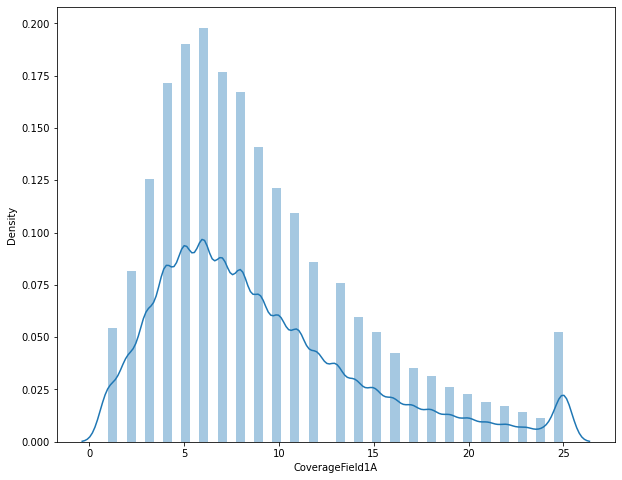

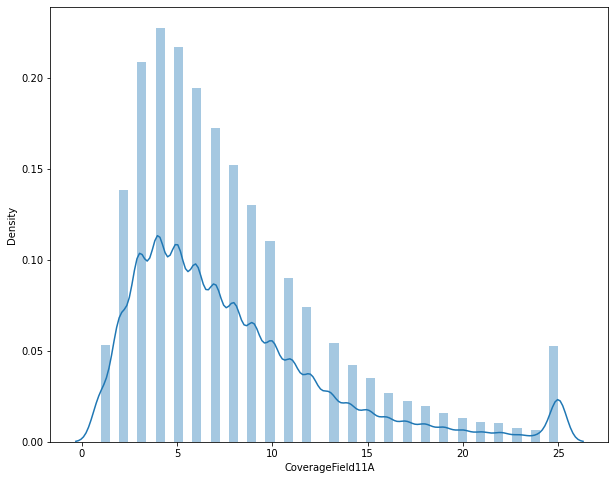

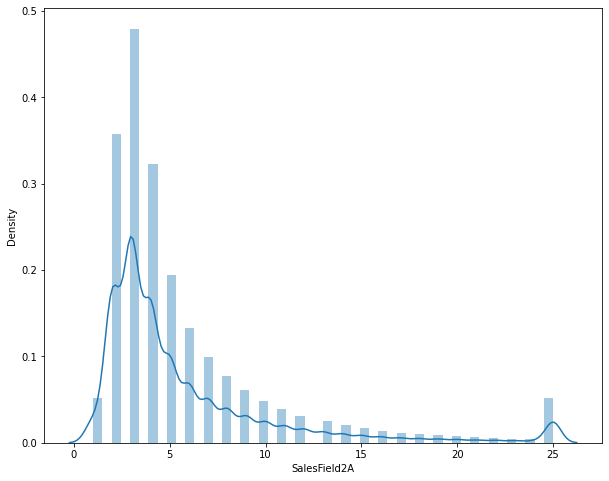

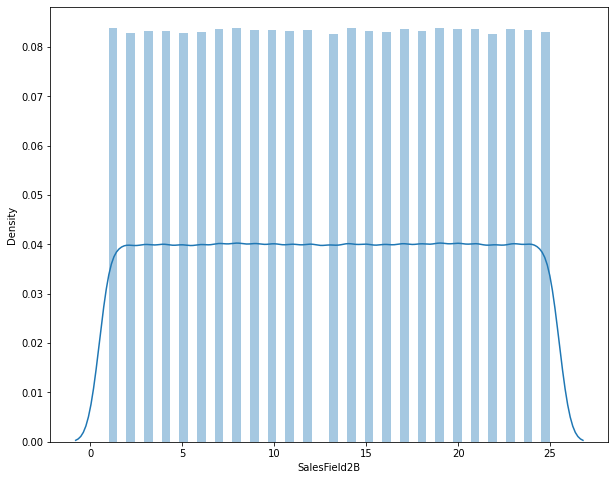

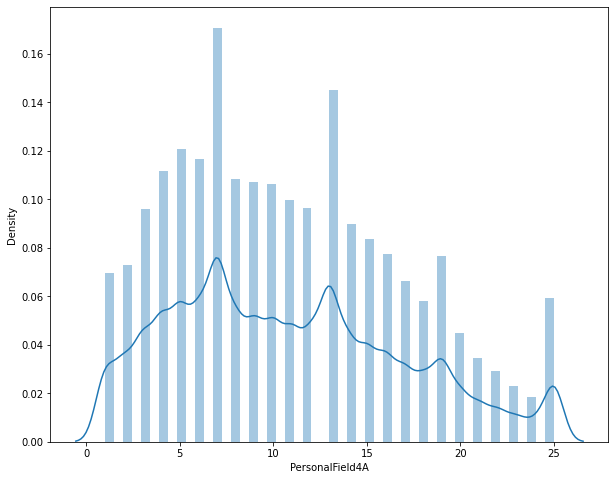

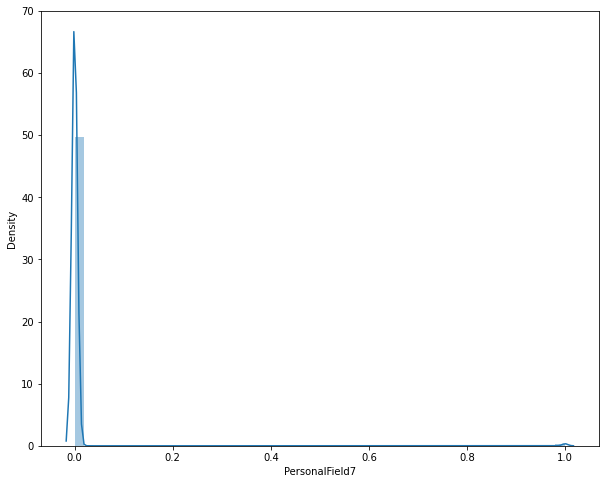

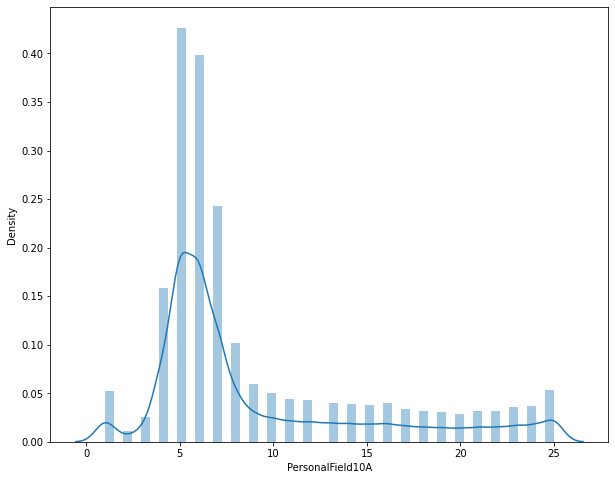

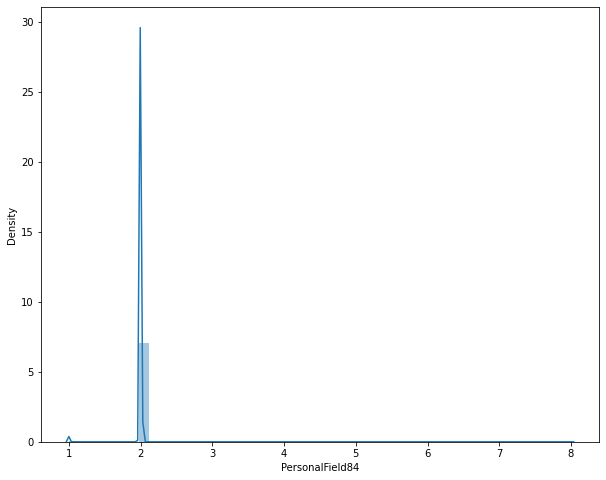

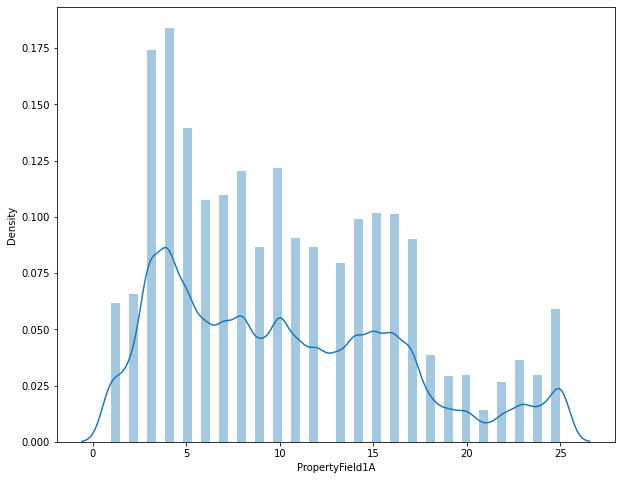

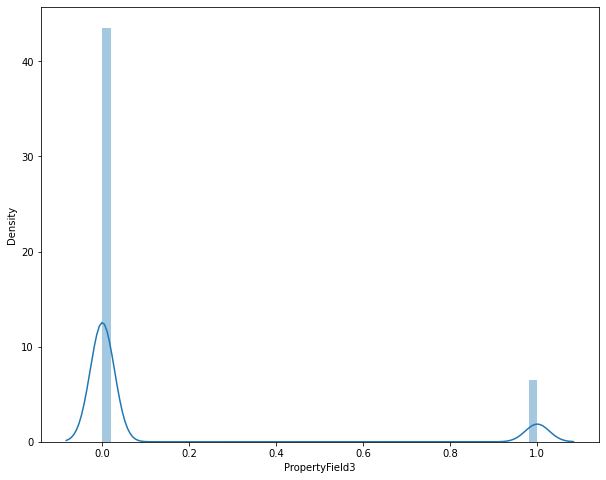

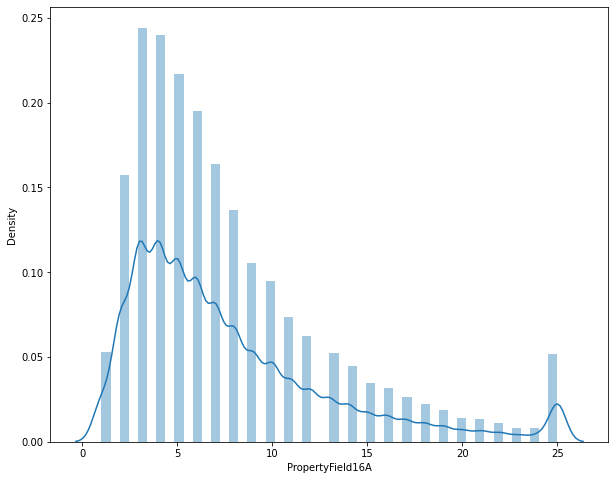

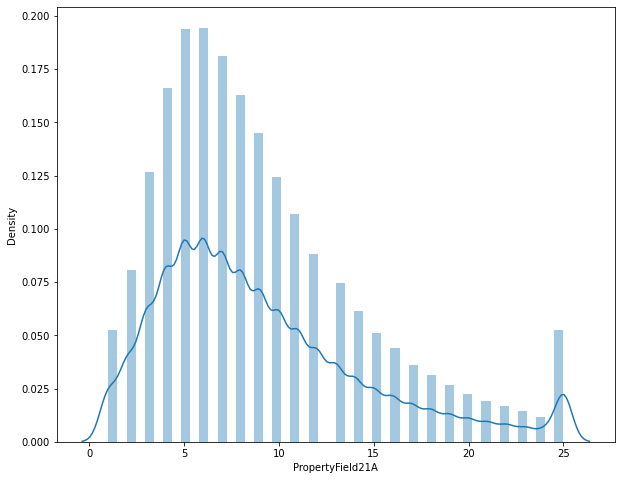

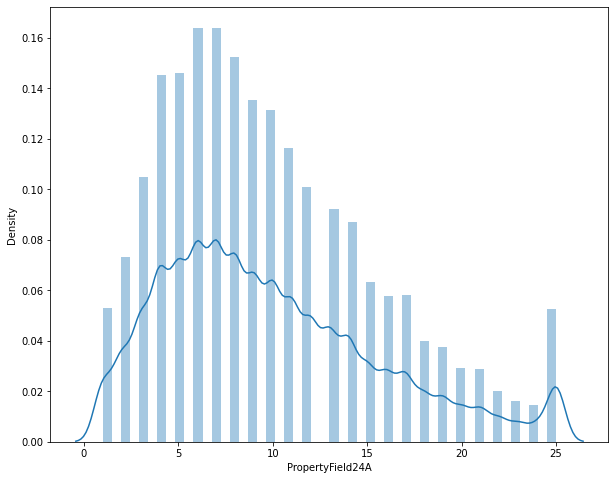

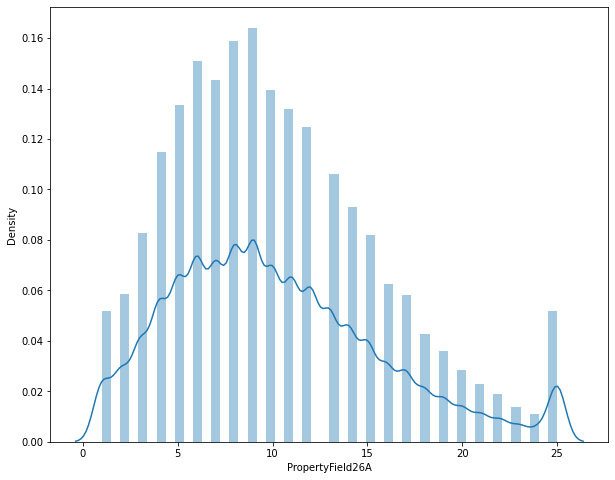

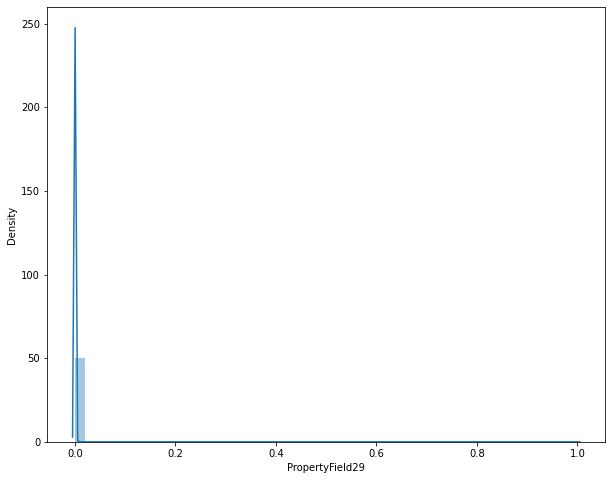

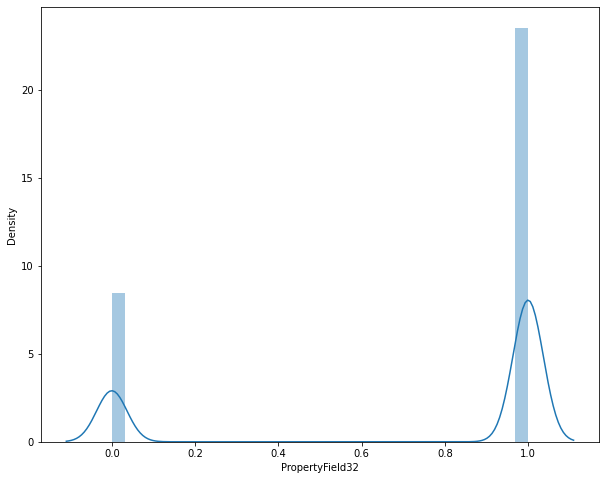

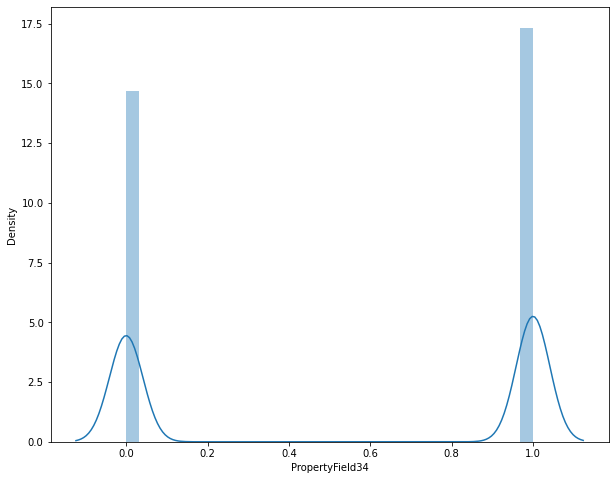

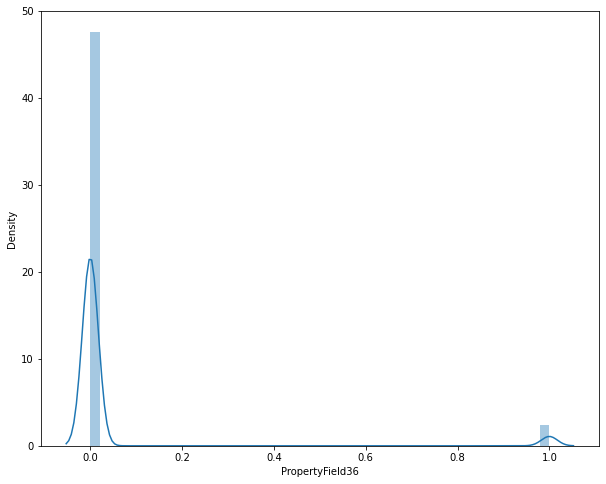

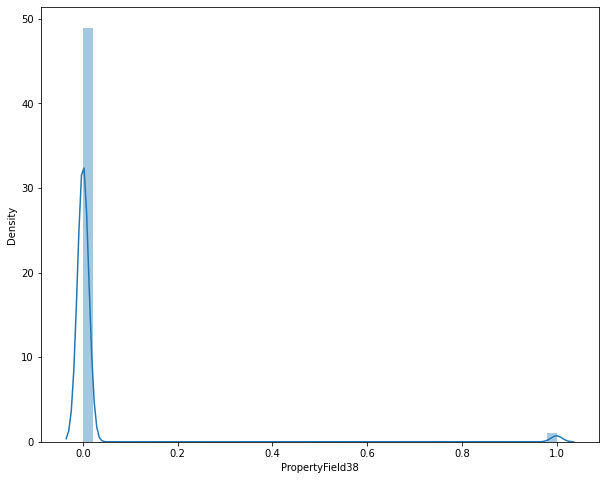

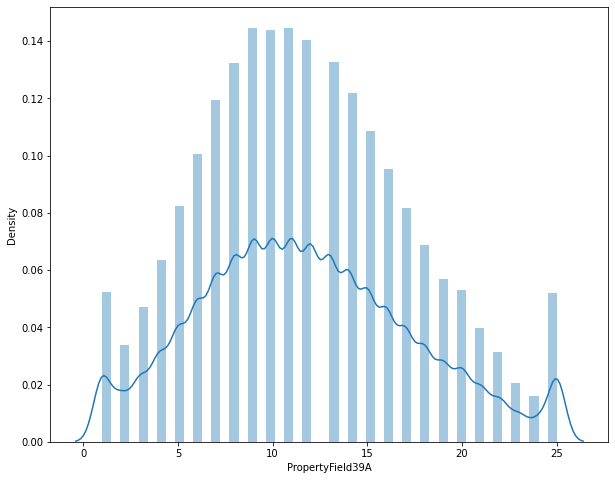

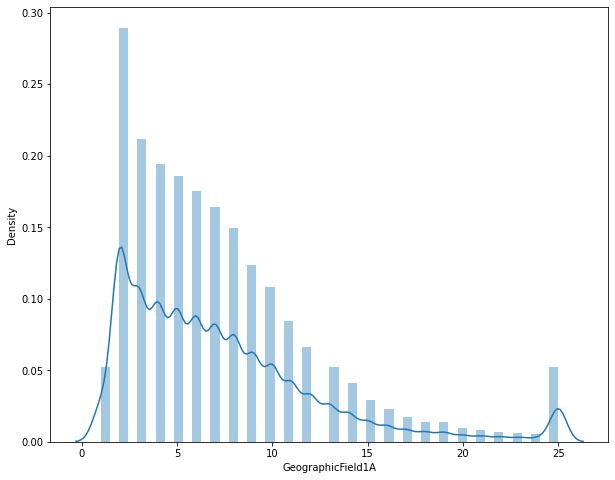

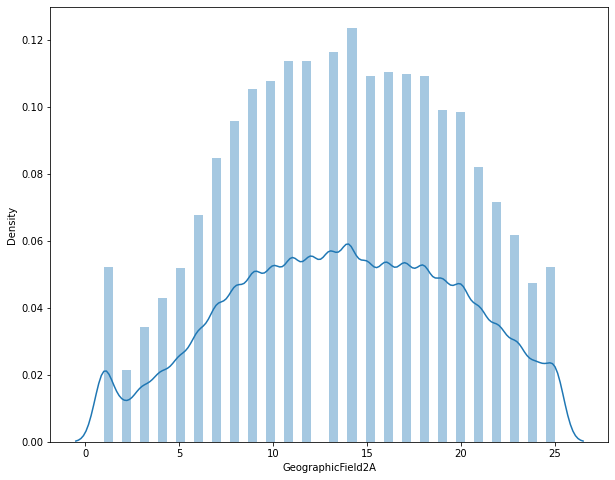

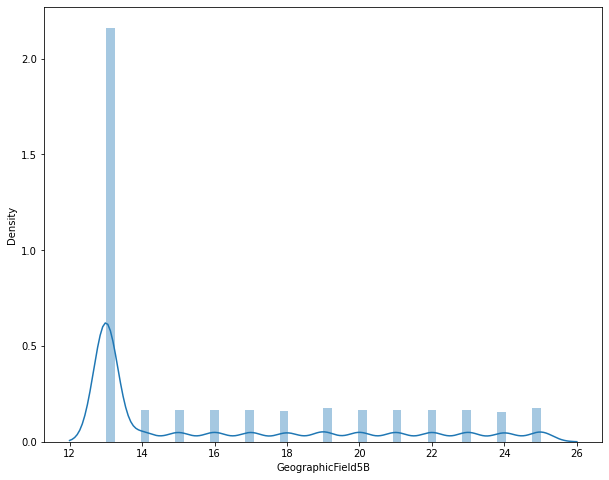

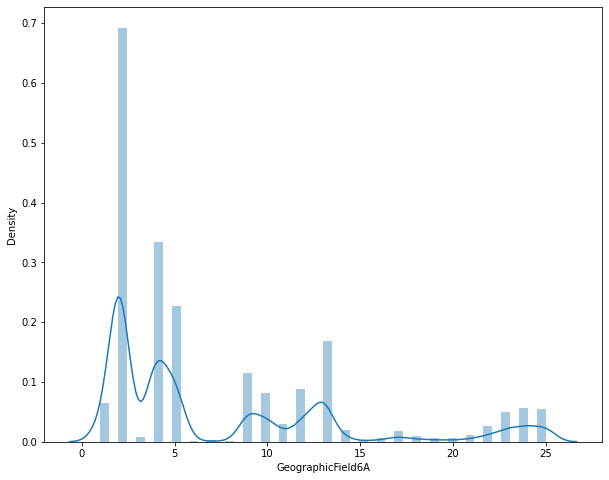

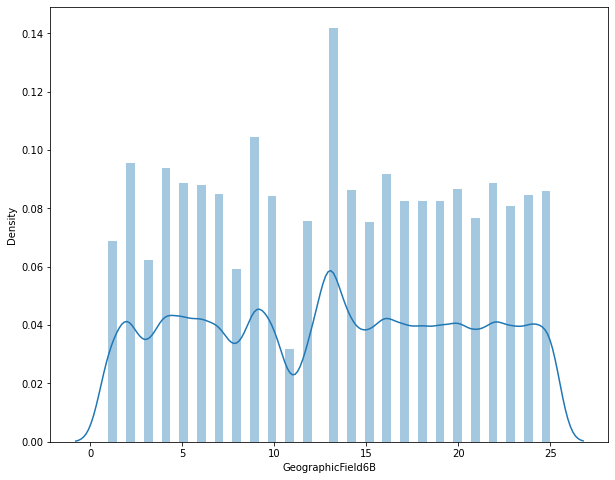

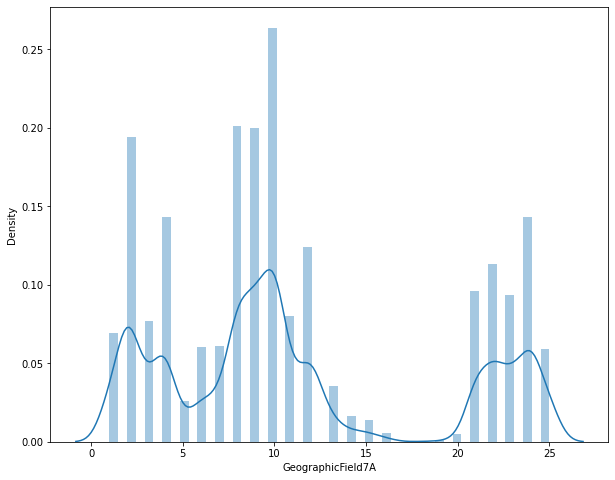

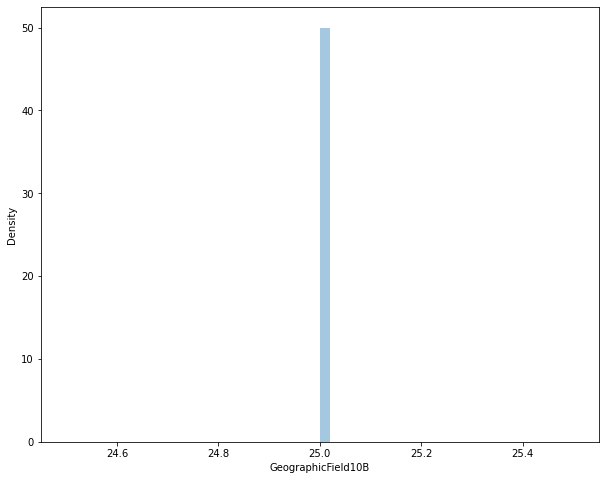

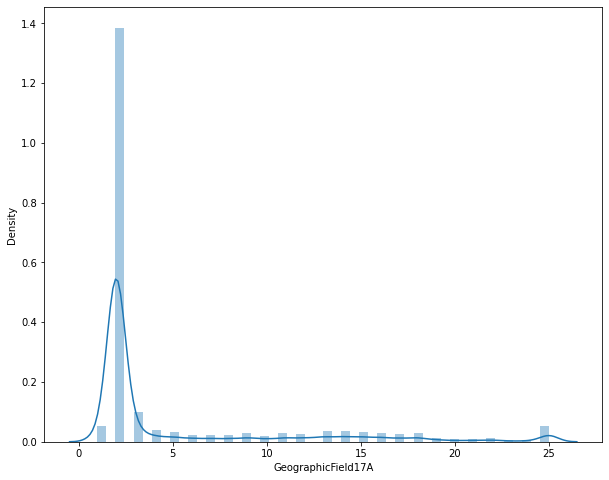

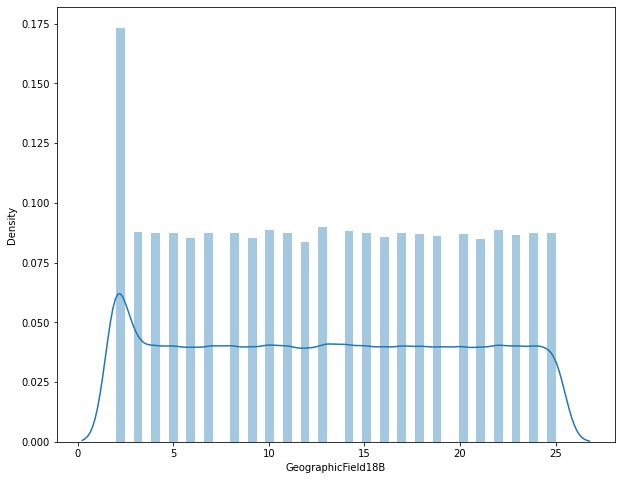

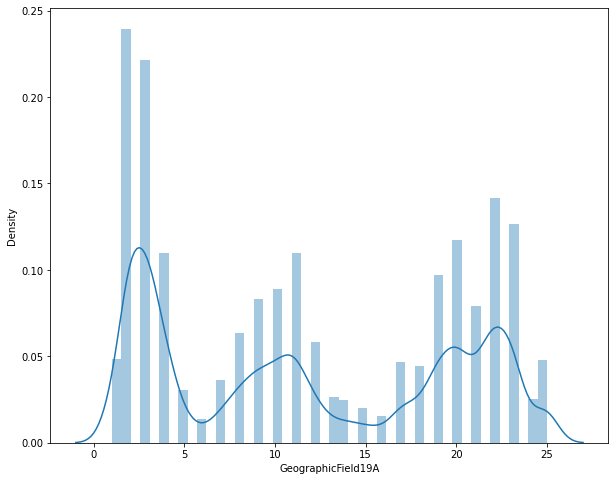

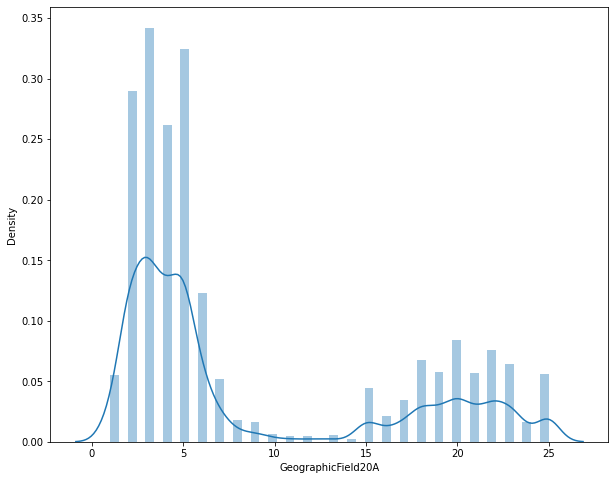

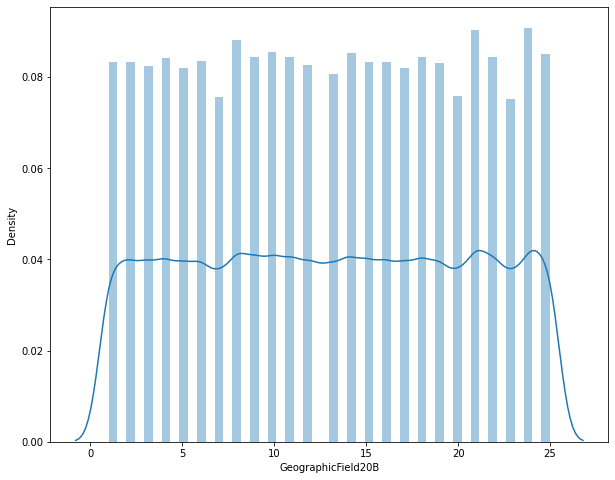

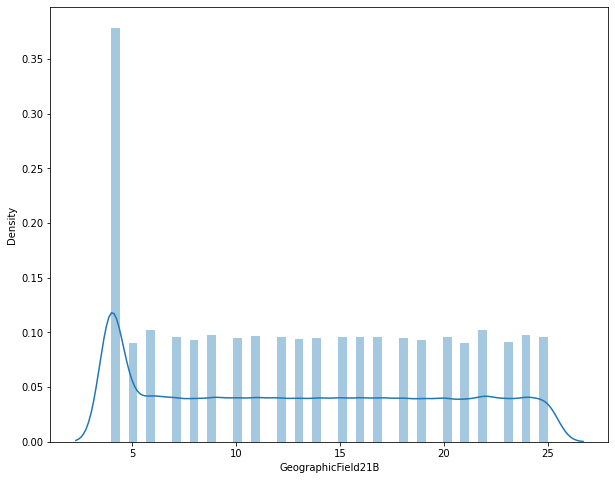

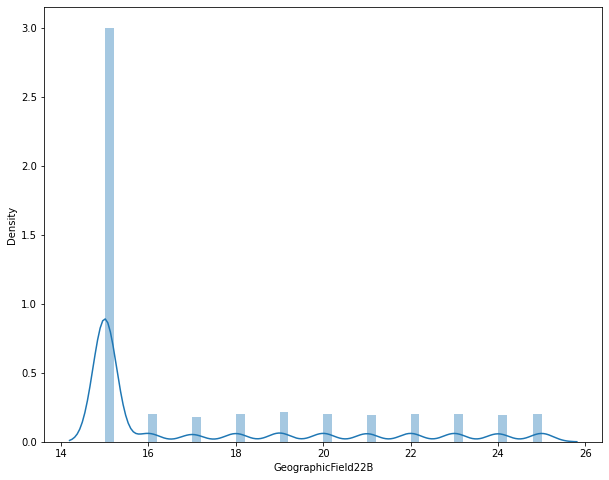

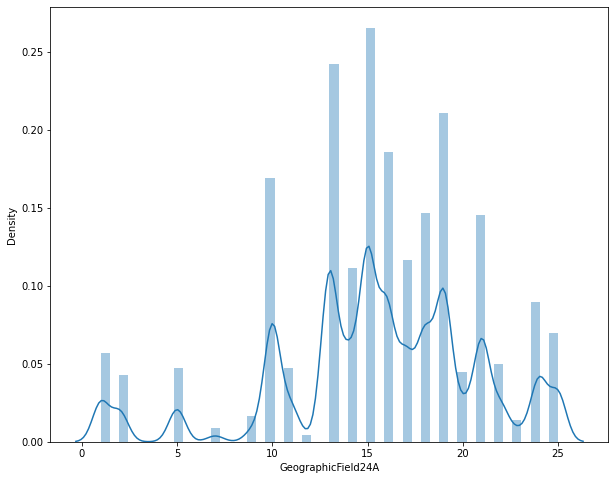

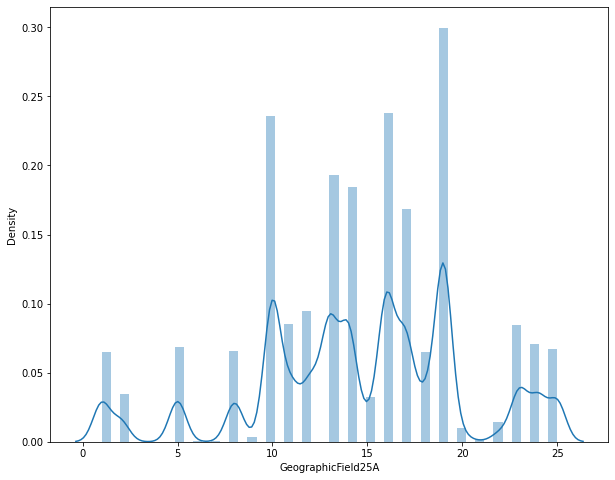

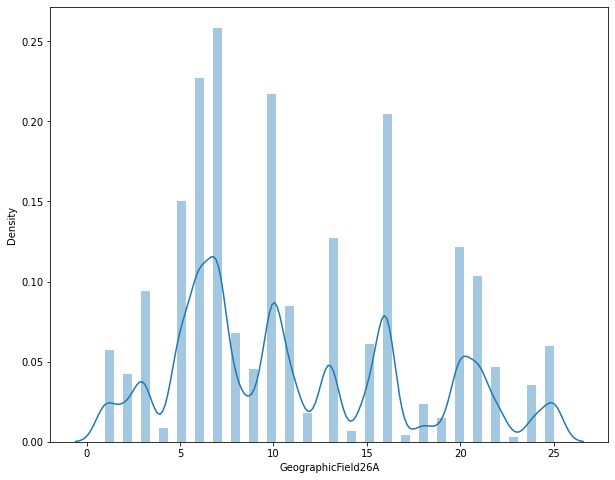

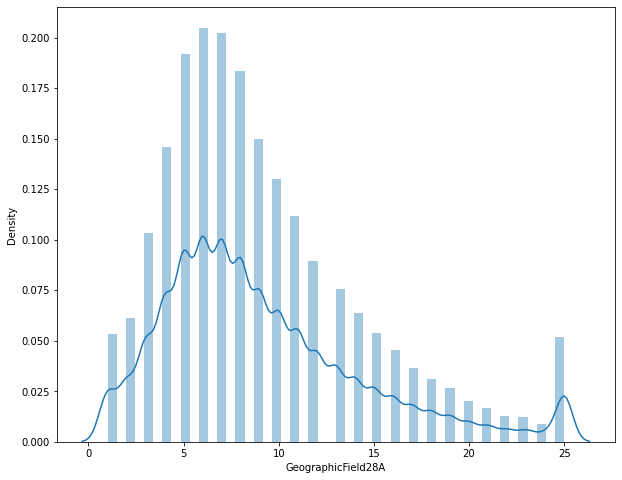

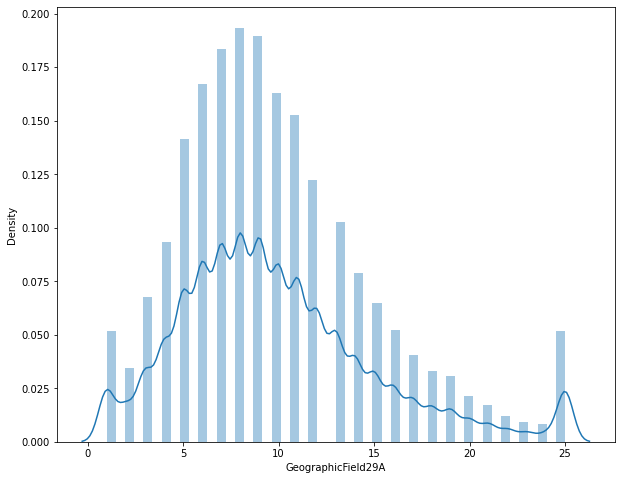

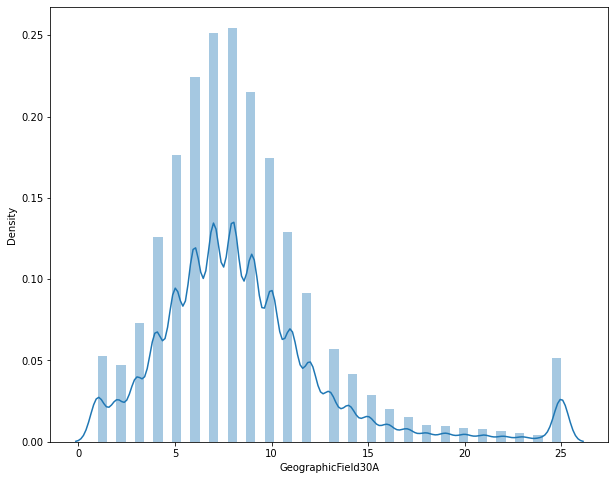

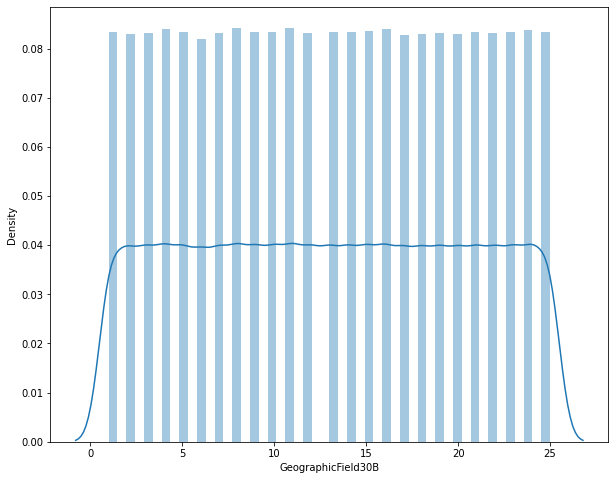

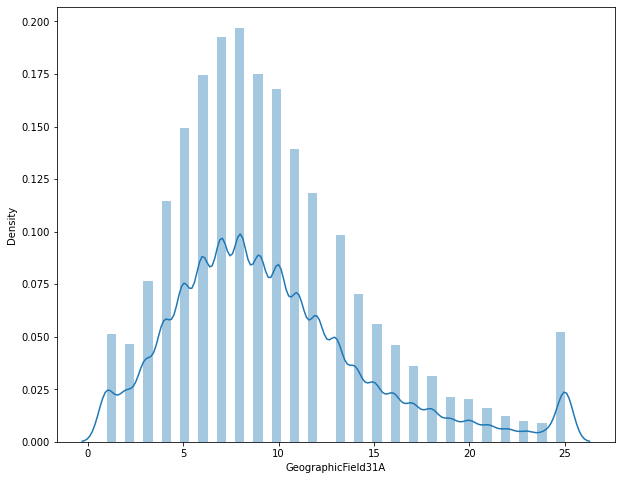

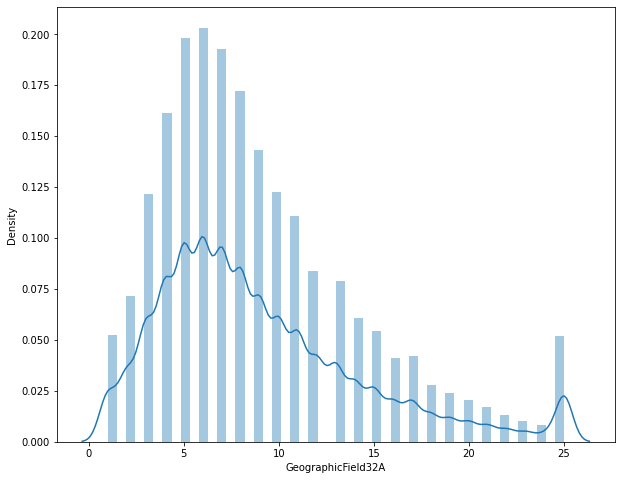

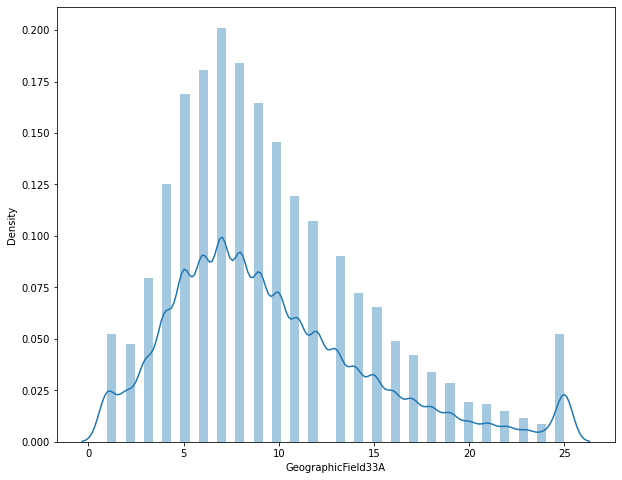

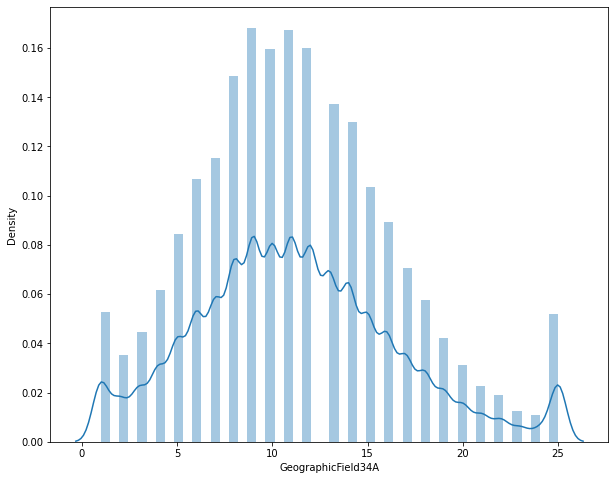

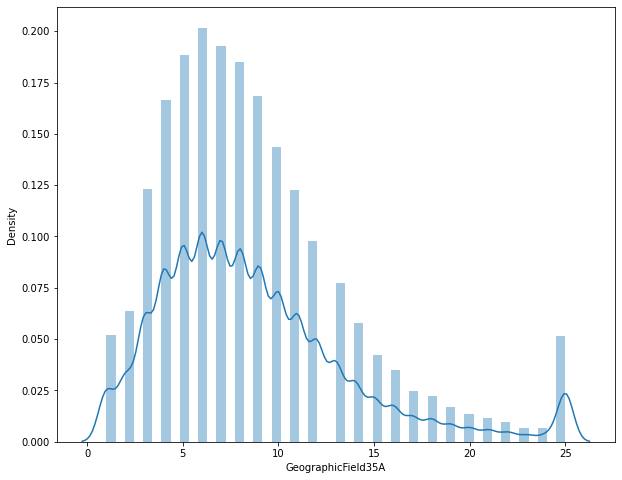

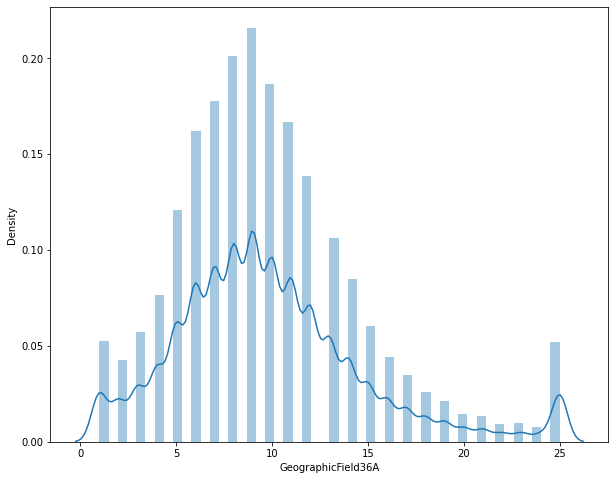

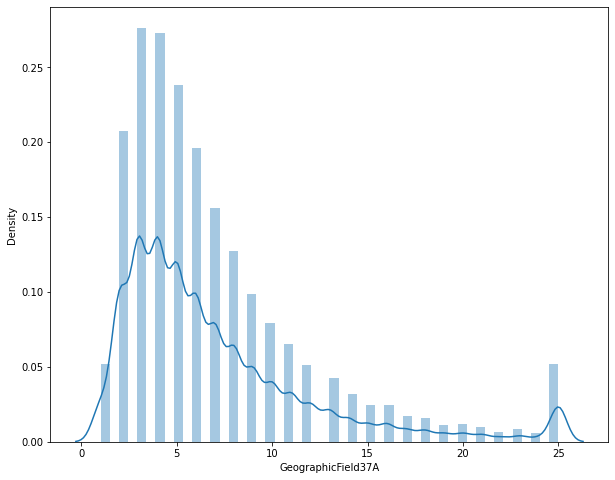

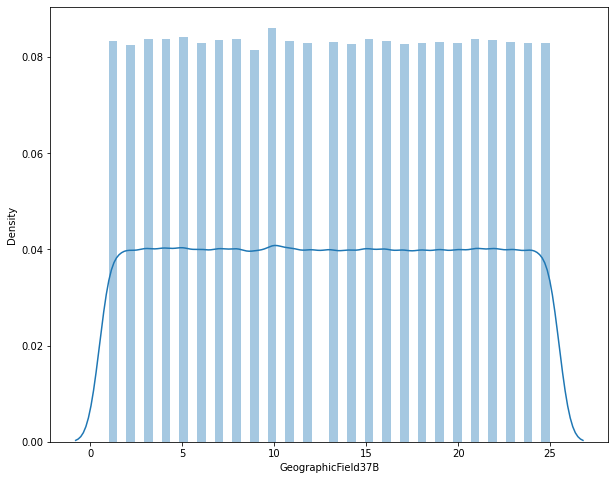

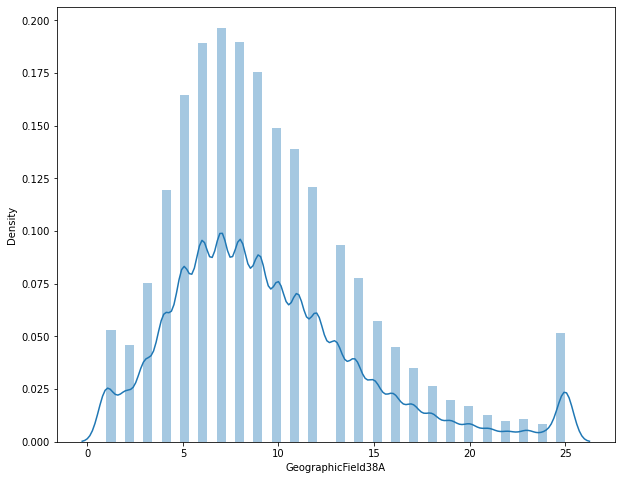

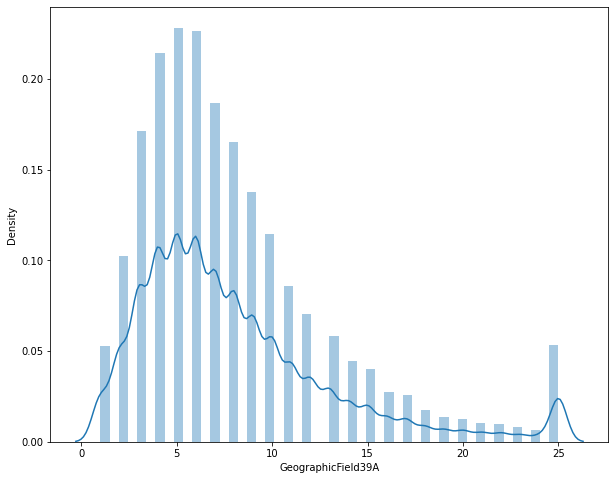

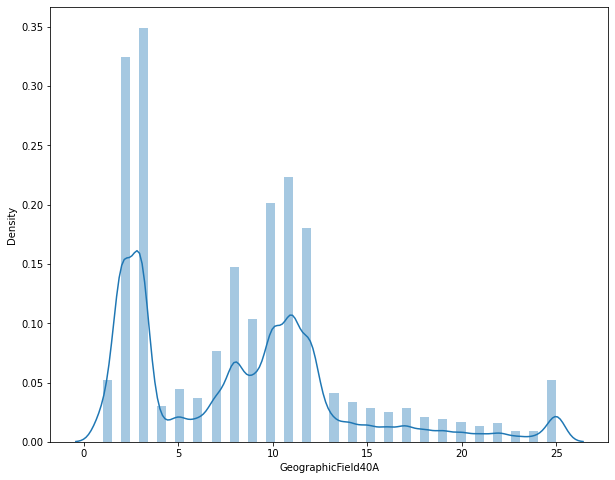

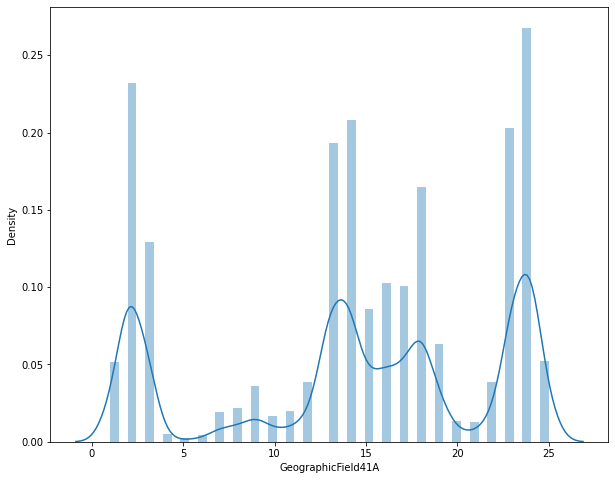

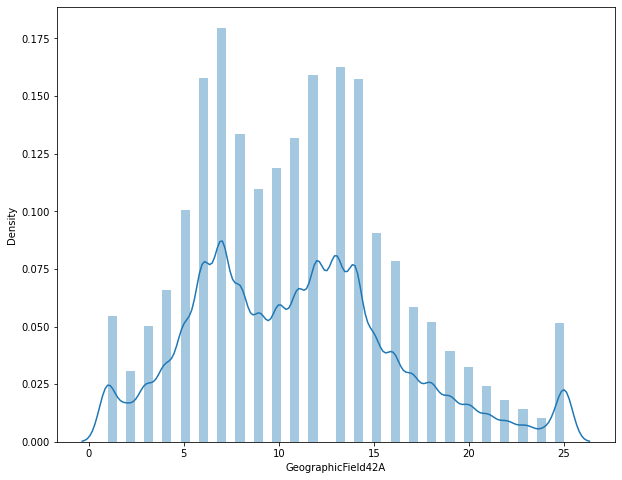

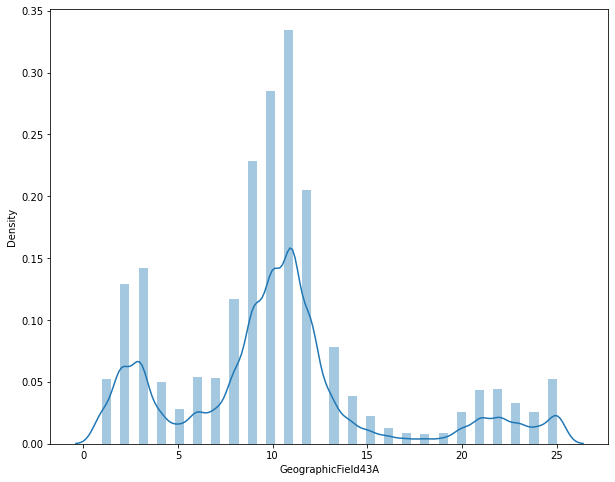

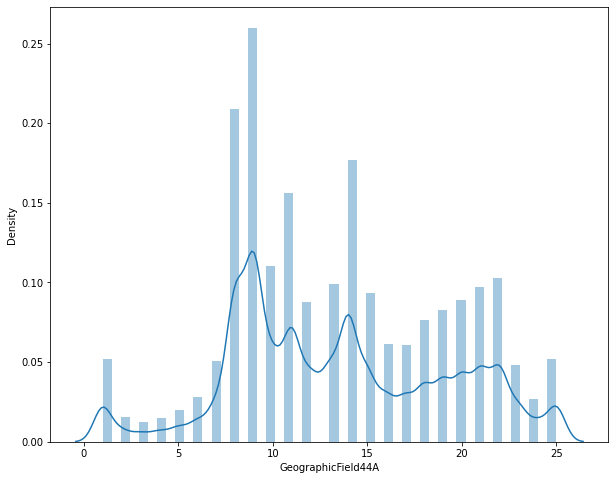

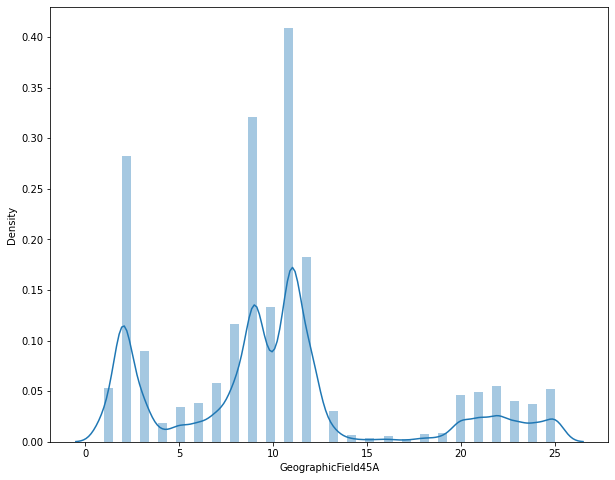

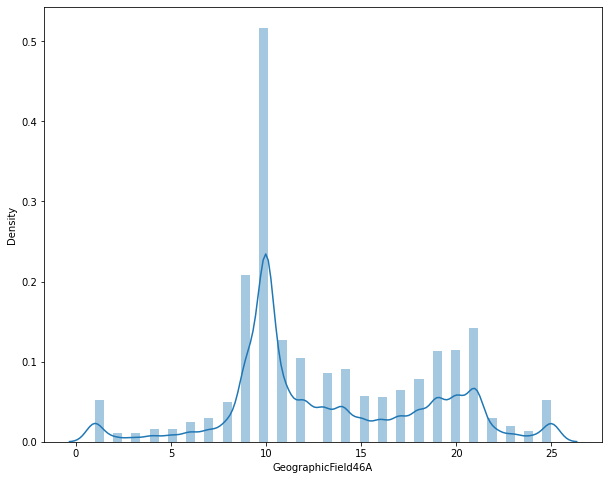

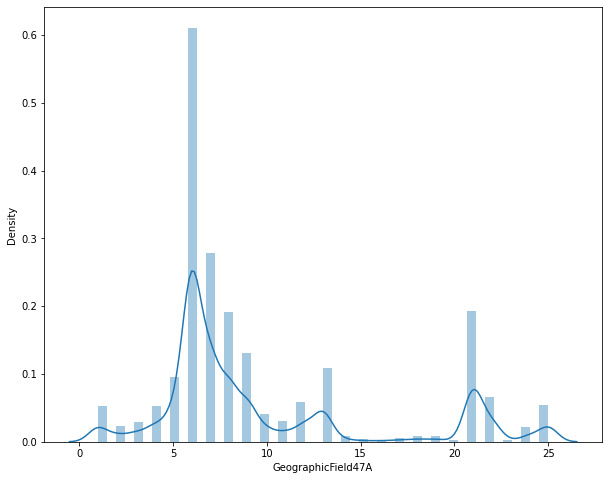

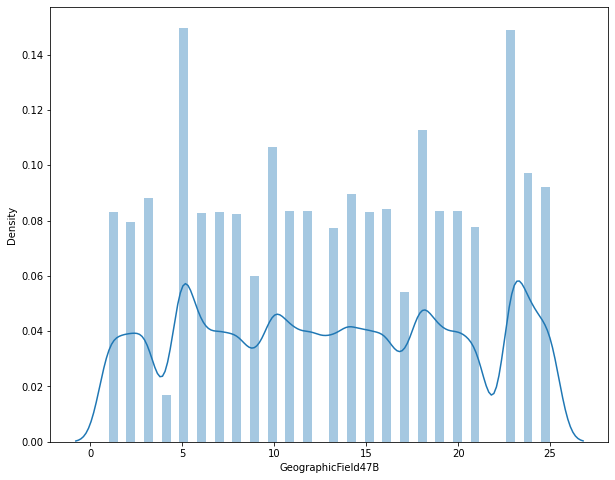

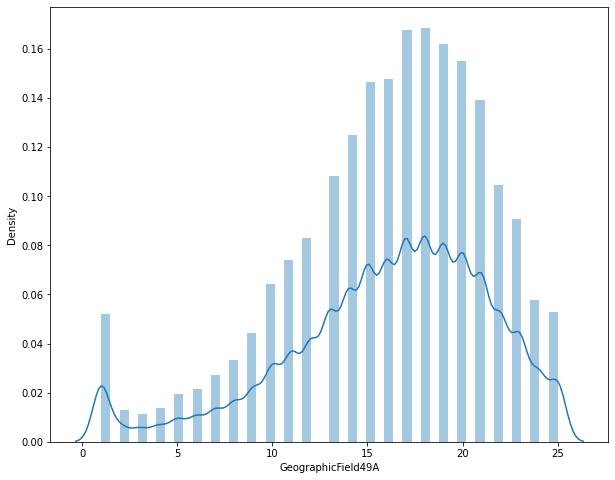

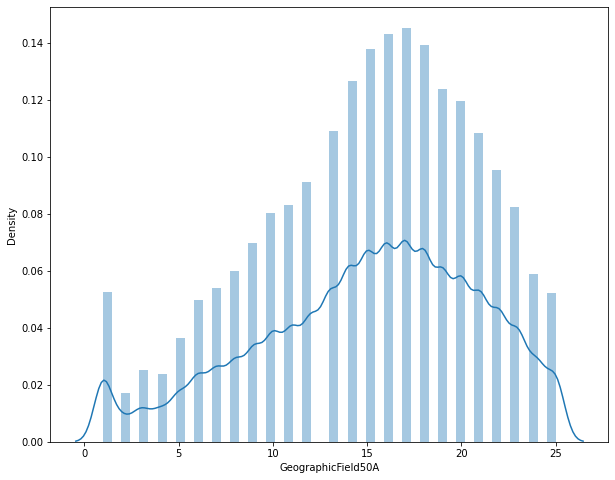

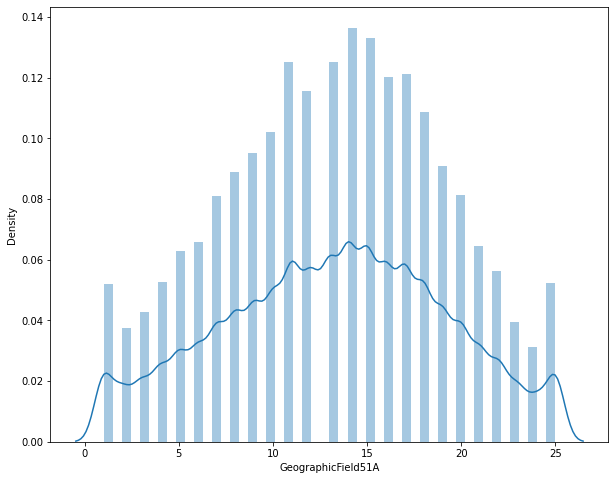

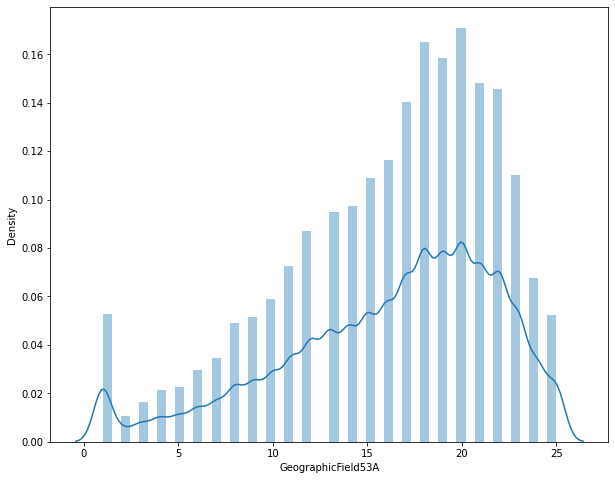

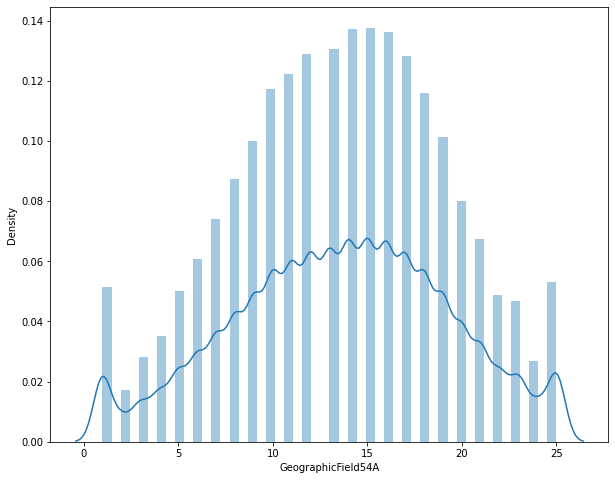

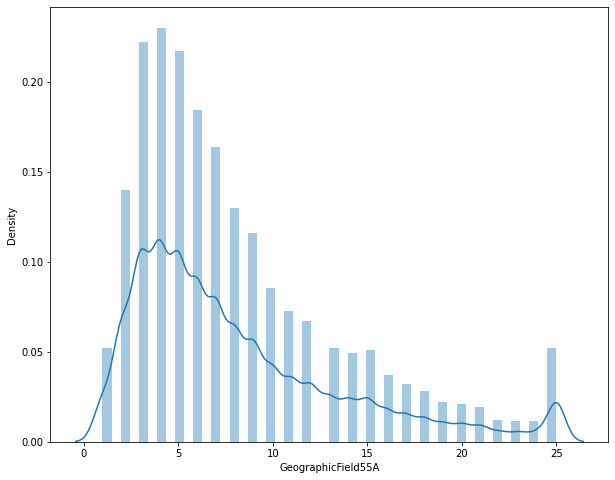

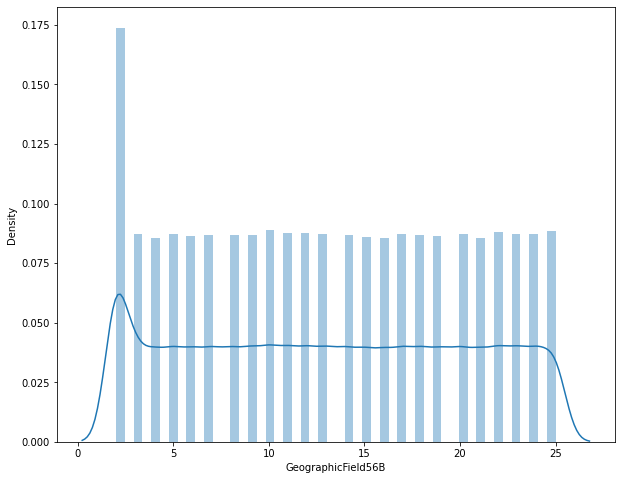

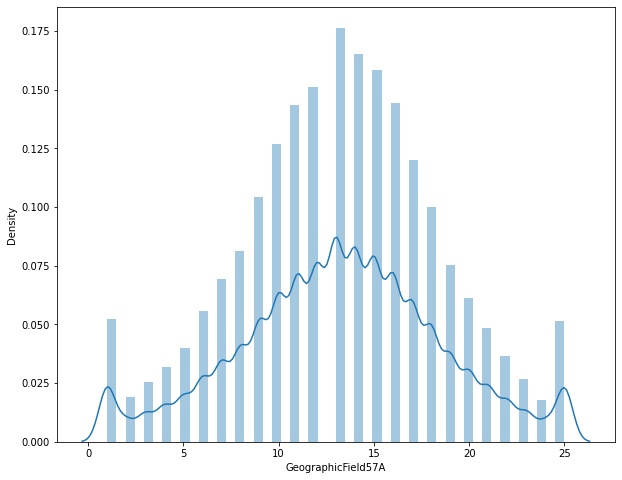

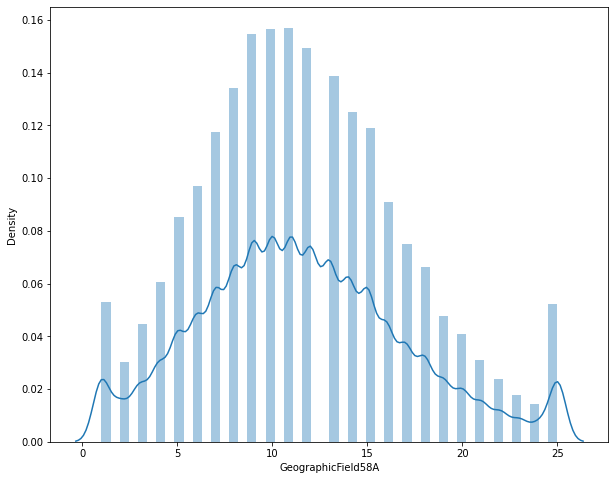

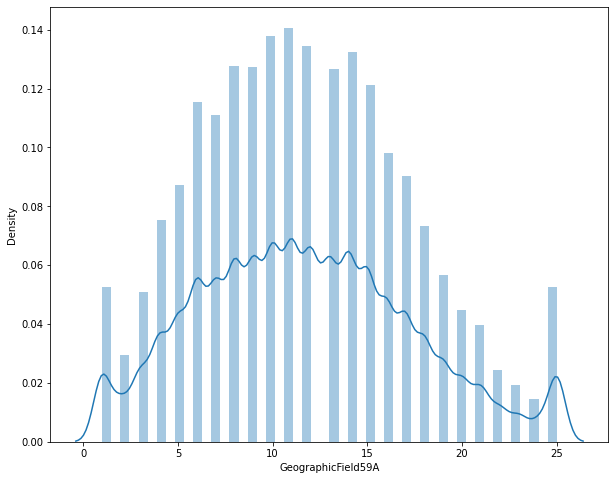

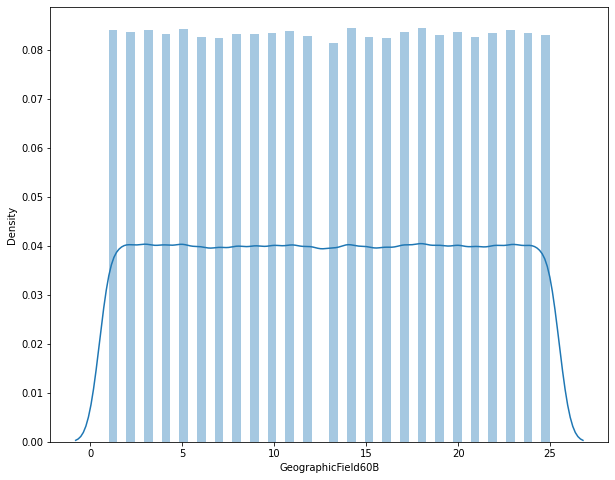

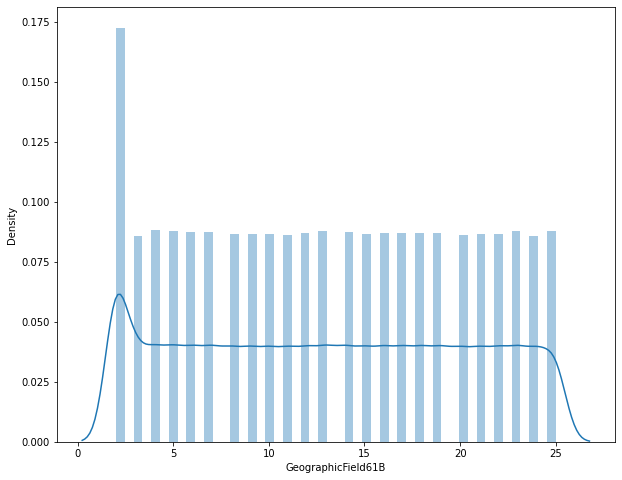

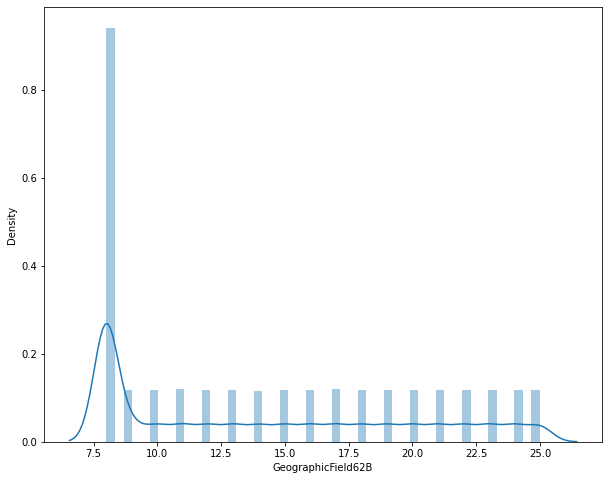

In [12]:
for i in df_nan_new_cnt['Field']:
  fig, ax = plt.subplots(figsize = (10, 8))
  sns.distplot(df[i])


***Observation:*** We have now plotted the distribution of all the 73 features to learn about the skewness of each feature.

---

**13. Dividing the featues based on their skewness.**
**If the feature is more skewed, then use Median based imputation, else use Mean based imputation.**

In [13]:
medianFields = ['SalesField2A',
'PersonalField7',
'PersonalField10A',
'PersonalField84',
'PropertyField3',
'PropertyField29',
'PropertyField32',
'PropertyField34',
'PropertyField36',
'PropertyField38',
'GeographicField1A',
'GeographicField5B',
'GeographicField17A',
'GeographicField22B',
'GeographicField37A',
'GeographicField47A',
'GeographicField62B',
'GeographicField10B']

meanFields = ['CoverageField1A',
'CoverageField11A',
'SalesField2B',
'PersonalField4A',
'PropertyField1A',
'PropertyField16A',
'PropertyField21A',
'PropertyField24A',
'PropertyField26A',
'PropertyField39A',
'GeographicField2A',
'GeographicField6A',
'GeographicField6B',
'GeographicField7A',
'GeographicField18B',
'GeographicField19A',
'GeographicField20A',
'GeographicField20B',
'GeographicField21B',
'GeographicField24A',
'GeographicField25A',
'GeographicField26A',
'GeographicField28A',
'GeographicField29A',
'GeographicField30A',
'GeographicField30B',
'GeographicField31A',
'GeographicField32A',
'GeographicField33A',
'GeographicField34A',
'GeographicField35A',
'GeographicField36A',
'GeographicField37B',
'GeographicField38A',
'GeographicField39A',
'GeographicField40A',
'GeographicField41A',
'GeographicField42A',
'GeographicField43A',
'GeographicField44A',
'GeographicField45A',
'GeographicField46A',
'GeographicField47B',
'GeographicField49A',
'GeographicField50A',
'GeographicField51A',
'GeographicField53A',
'GeographicField54A',
'GeographicField55A',
'GeographicField56B',
'GeographicField57A',
'GeographicField58A',
'GeographicField59A',
'GeographicField60B',
'GeographicField61B']

for i in medianFields:
  df[i] = df[i].fillna(df[i].median())

for i in meanFields:
  df[i] = df[i].fillna(df[i].mean())

print('Total number of features for Median based imputation is: {0}'.format(len(medianFields)))
print('Total number of features for Mean based imputation is: {0}'.format(len(meanFields)))

Total number of features for Median based imputation is: 18
Total number of features for Mean based imputation is: 55


**14. Re-checking if there are any missing values in any feature.**

---

In [14]:
#Again calculate the Features and their NaN percentage.
# It should be blank as we have converted all NULL/NaN features to Numeric.

total_count = df.shape[0]

print("Features having Empty/NULL/NaN value count!\n-------------------------------------------")
dfsr = df.isnull().sum()
df_nan = dfsr[dfsr.values != 0].to_frame().to_string()
#df_nan

#Give names to the output data
df_nan_new = pd.read_csv(StringIO(df_nan), sep='\s+', names = ['Field', 'Nan_Count', 'Nan_Percent'])

df_nan_new = df_nan_new[df_nan_new.Field != '0']

# Get the NaN percentage from the total count.
df_null = df[df.columns[df.eq(-1).any()]]

total_null_cols = df_null.columns

nan_new_count = df_nan_new['Field'].count()

total_null_cols

Features having Empty/NULL/NaN value count!
-------------------------------------------


Index([], dtype='object')

***Observation:*** There are no Empty/NULL/NaN values in any of the feature.

---

**15. Grouping the features.**

---

In [15]:
field_cols = []
for i in df.columns:
  if i.startswith('Field'):
    field_cols.append(i)

coverage_field_cols = []
for i in df.columns:
  if i.startswith('CoverageField'):
    coverage_field_cols.append(i)

sales_field_cols = []
for i in df.columns:
  if i.startswith('SalesField'):
    sales_field_cols.append(i)

personal_field_cols = []
for i in df.columns:
  if i.startswith('PersonalField'):
    personal_field_cols.append(i)

property_field_cols = []
for i in df.columns:
  if i.startswith('PropertyField'):
    property_field_cols.append(i)

graphic_field_cols = []
for i in df.columns:
  if i.startswith('GeographicField'):
    graphic_field_cols.append(i)

all_features_list = ['field_cols', 'coverage_field_cols', 'sales_field_cols', 'personal_field_cols', 'property_field_cols', 'graphic_field_cols']


**16. Get the top correlated feature having correlated value > 0.70 and lessthan 1.000000 for each grouped features.**

---

**16.a. Field Features**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['Field8', 'Field9']


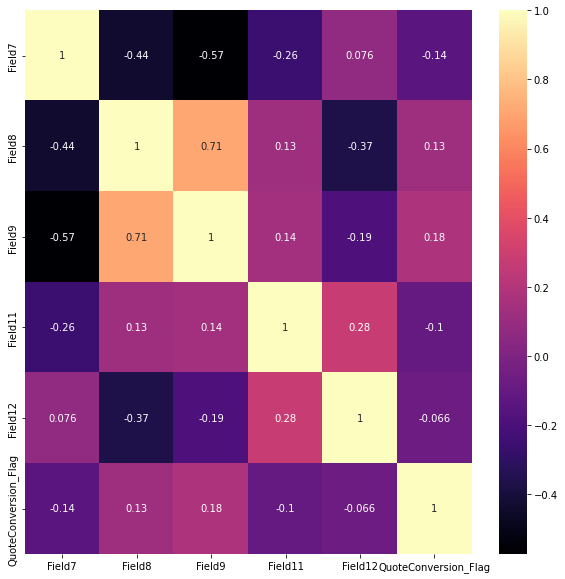

In [16]:
y = df['QuoteConversion_Flag']
X_field = df[field_cols]
X_field['QuoteConversion_Flag'] = df['QuoteConversion_Flag']

corr_mat = X_field.corr()
top_corr_features_field = corr_mat.index
plt.figure(figsize=(10,10))

h = sns.heatmap(X_field[top_corr_features_field].corr(), annot = True, cmap = "magma")

final_field_feature = []
final_field_feature = X_field[top_corr_features_field].corr()[(X_field[top_corr_features_field].corr().values > 0.70) & (X_field[top_corr_features_field].corr().values < 1.000000)].index.unique()

final_features = []
final_features.extend(final_field_feature.values)

print(final_features)

**16.b. Coverage Field Features**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['Field8', 'Field9', 'CoverageField5A', 'CoverageField5B', 'CoverageField6A', 'CoverageField6B']


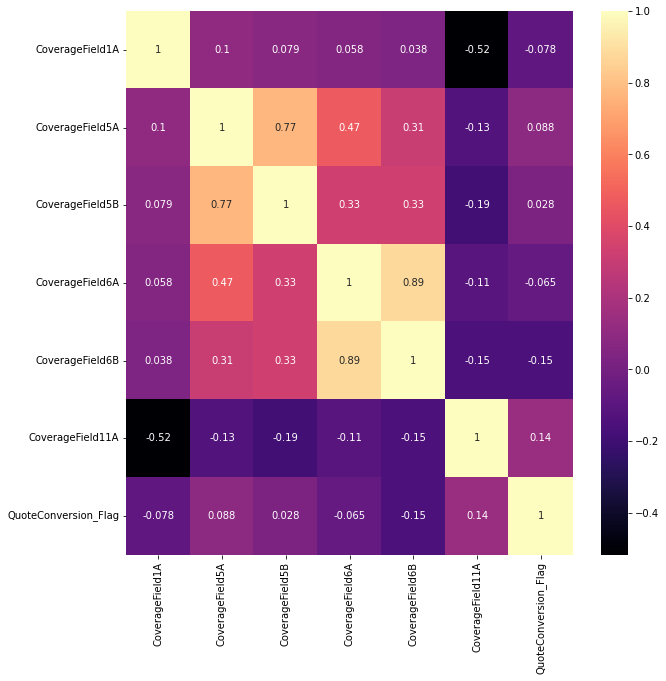

In [17]:
X_cov_field = df[coverage_field_cols]
X_cov_field['QuoteConversion_Flag'] = df['QuoteConversion_Flag']

corr_mat = X_cov_field.corr()
top_corr_features_cov_field = corr_mat.index
plt.figure(figsize=(10,10))

h = sns.heatmap(X_cov_field[top_corr_features_cov_field].corr(), annot = True, cmap = "magma")

final_cov_field_feature = []
final_cov_field_feature = X_cov_field[top_corr_features_cov_field].corr()[(X_cov_field[top_corr_features_cov_field].corr().values > 0.70) & (X_cov_field[top_corr_features_cov_field].corr().values < 1.000000)].index.unique()

final_features.extend(final_cov_field_feature.values)

print(final_features)

**16.c. Sales Field Features**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['Field8', 'Field9', 'CoverageField5A', 'CoverageField5B', 'CoverageField6A', 'CoverageField6B', 'SalesField1A', 'SalesField1B', 'SalesField2A', 'SalesField2B', 'SalesField4', 'SalesField5', 'SalesField10', 'SalesField11', 'SalesField13', 'SalesField14']


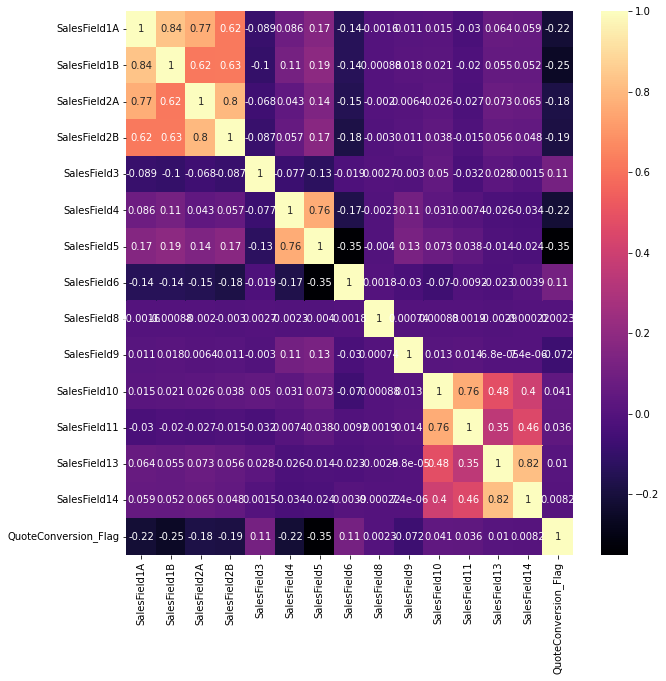

In [18]:
X_sales_field = df[sales_field_cols]
X_sales_field['QuoteConversion_Flag'] = df['QuoteConversion_Flag']

corr_mat = X_sales_field.corr()
top_corr_features_sales_field = corr_mat.index
plt.figure(figsize=(10,10))

h = sns.heatmap(X_sales_field[top_corr_features_sales_field].corr(), annot = True, cmap = "magma")

final_sales_field_feature = []
final_sales_field_feature = X_sales_field[top_corr_features_sales_field].corr()[(X_sales_field[top_corr_features_sales_field].corr().values > 0.70) & (X_sales_field[top_corr_features_sales_field].corr().values < 1.000000)].index.unique()

final_features.extend(final_sales_field_feature.values)

print(final_features)

**16.d. Personal Field Features**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['Field8', 'Field9', 'CoverageField5A', 'CoverageField5B', 'CoverageField6A', 'CoverageField6B', 'SalesField1A', 'SalesField1B', 'SalesField2A', 'SalesField2B', 'SalesField4', 'SalesField5', 'SalesField10', 'SalesField11', 'SalesField13', 'SalesField14', 'PersonalField15', 'PersonalField22', 'PersonalField27', 'PersonalField28', 'PersonalField29', 'PersonalField30', 'PersonalField31', 'PersonalField39', 'PersonalField40', 'PersonalField64', 'PersonalField65', 'PersonalField66', 'PersonalField67', 'PersonalField69', 'PersonalField70', 'PersonalField74', 'PersonalField79']


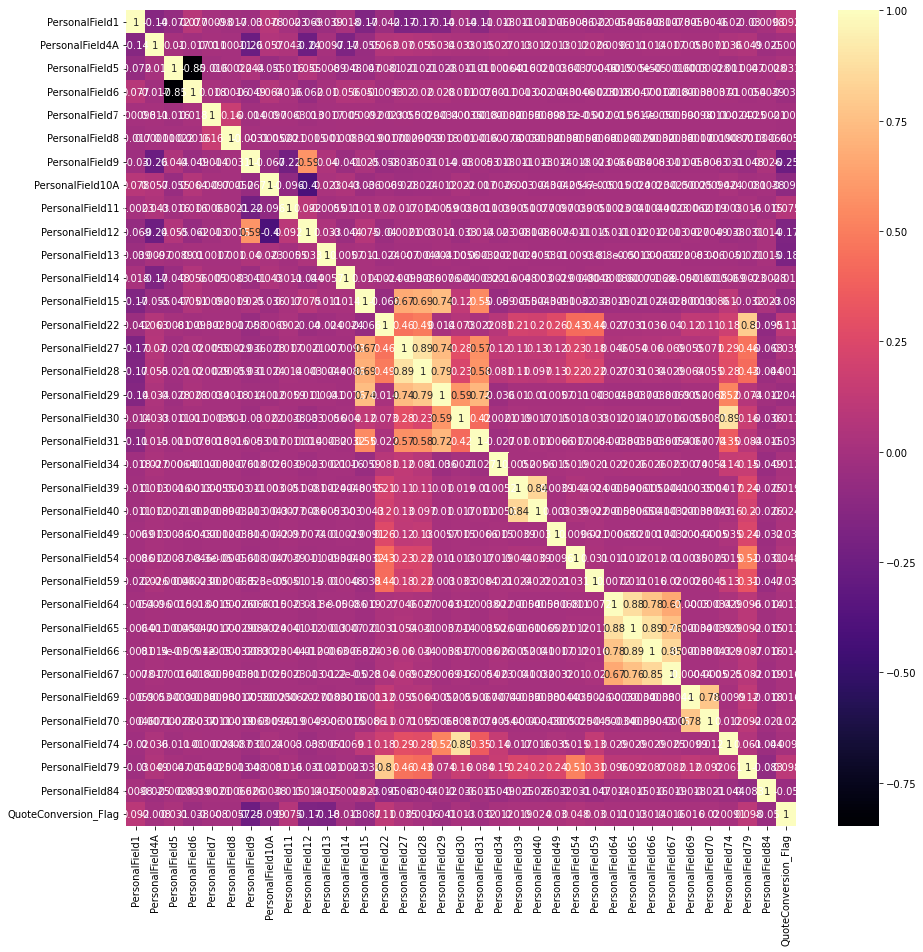

In [19]:
X_personal_field = df[personal_field_cols]
X_personal_field['QuoteConversion_Flag'] = df['QuoteConversion_Flag']

corr_mat = X_personal_field.corr()
top_corr_features_personal_field = corr_mat.index
plt.figure(figsize=(15,15))

h = sns.heatmap(X_personal_field[top_corr_features_personal_field].corr(), annot = True, cmap = "magma")

final_personal_field_feature = []
final_personal_field_feature = X_personal_field[top_corr_features_personal_field].corr()[(X_personal_field[top_corr_features_personal_field].corr().values > 0.70) & (X_personal_field[top_corr_features_personal_field].corr().values < 1.000000)].index.unique()

final_features.extend(final_personal_field_feature.values)

print(final_features)

**16.e. Property Field Features**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['Field8', 'Field9', 'CoverageField5A', 'CoverageField5B', 'CoverageField6A', 'CoverageField6B', 'SalesField1A', 'SalesField1B', 'SalesField2A', 'SalesField2B', 'SalesField4', 'SalesField5', 'SalesField10', 'SalesField11', 'SalesField13', 'SalesField14', 'PersonalField15', 'PersonalField22', 'PersonalField27', 'PersonalField28', 'PersonalField29', 'PersonalField30', 'PersonalField31', 'PersonalField39', 'PersonalField40', 'PersonalField64', 'PersonalField65', 'PersonalField66', 'PersonalField67', 'PersonalField69', 'PersonalField70', 'PersonalField74', 'PersonalField79', 'PropertyField21A', 'PropertyField24A', 'PropertyField32', 'PropertyField35']


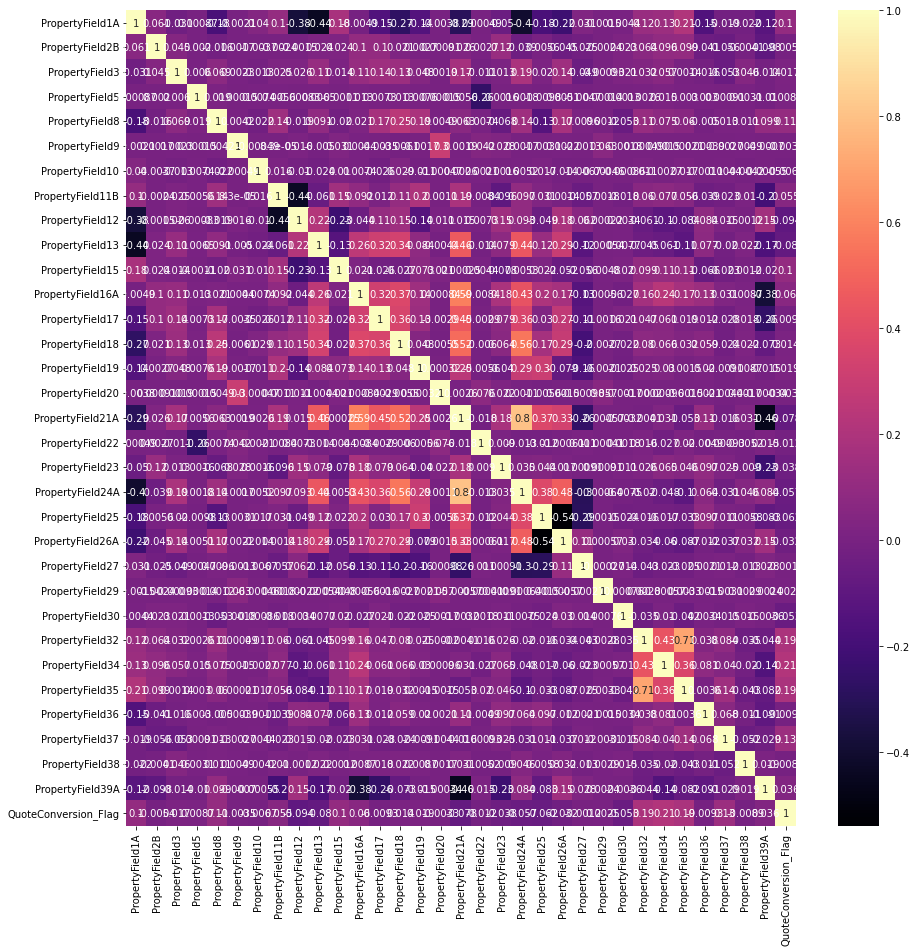

In [20]:
X_property_field = df[property_field_cols]
X_property_field['QuoteConversion_Flag'] = df['QuoteConversion_Flag']

corr_mat = X_property_field.corr()
top_corr_features_property_field = corr_mat.index
plt.figure(figsize=(15,15))

h = sns.heatmap(X_property_field[top_corr_features_property_field].corr(), annot = True, cmap = "magma")

final_property_field_feature = []
final_property_field_feature = X_property_field[top_corr_features_property_field].corr()[(X_property_field[top_corr_features_property_field].corr().values > 0.70) & (X_property_field[top_corr_features_property_field].corr().values < 1.000000)].index.unique()

final_features.extend(final_property_field_feature.values)

print(final_features)

**16.f. Graphic Field Features**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['Field8', 'Field9', 'CoverageField5A', 'CoverageField5B', 'CoverageField6A', 'CoverageField6B', 'SalesField1A', 'SalesField1B', 'SalesField2A', 'SalesField2B', 'SalesField4', 'SalesField5', 'SalesField10', 'SalesField11', 'SalesField13', 'SalesField14', 'PersonalField15', 'PersonalField22', 'PersonalField27', 'PersonalField28', 'PersonalField29', 'PersonalField30', 'PersonalField31', 'PersonalField39', 'PersonalField40', 'PersonalField64', 'PersonalField65', 'PersonalField66', 'PersonalField67', 'PersonalField69', 'PersonalField70', 'PersonalField74', 'PersonalField79', 'PropertyField21A', 'PropertyField24A', 'PropertyField32', 'PropertyField35', 'GeographicField3A', 'GeographicField6A', 'GeographicField6B', 'GeographicField7A', 'GeographicField19A', 'GeographicField20A', 'GeographicField20B', 'GeographicField21B', 'GeographicField22B', 'GeographicField24A', 'GeographicField25A', 'GeographicField26A', 'GeographicField30A', 'GeographicField30B', 'GeographicField36A', 'GeographicField37

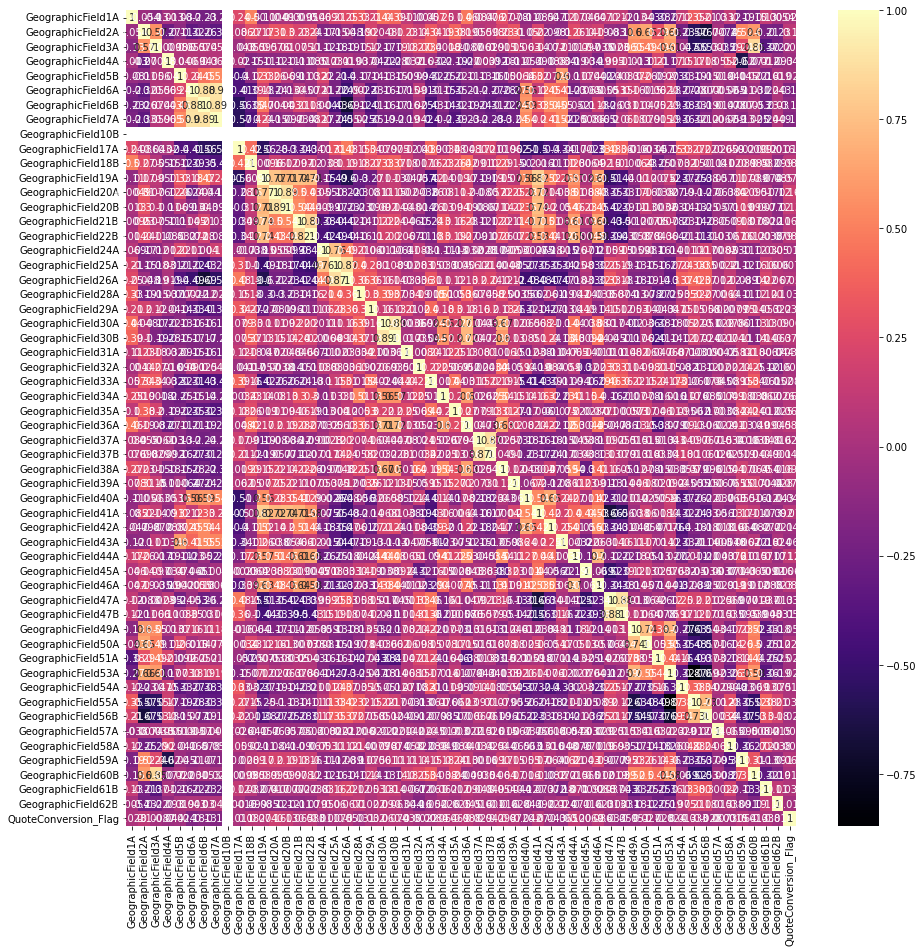

In [21]:
X_graphic_field = df[graphic_field_cols]
X_graphic_field['QuoteConversion_Flag'] = df['QuoteConversion_Flag']

corr_mat = X_graphic_field.corr()
top_corr_features_graphic_field = corr_mat.index
plt.figure(figsize=(15,15))

h = sns.heatmap(X_graphic_field[top_corr_features_graphic_field].corr(), annot = True, cmap = "magma")

final_graphic_field_feature = []
final_graphic_field_feature = X_graphic_field[top_corr_features_graphic_field].corr()[(X_graphic_field[top_corr_features_graphic_field].corr().values > 0.70) & (X_graphic_field[top_corr_features_graphic_field].corr().values < 1.000000)].index.unique()

final_features.extend(final_graphic_field_feature.values)

print(final_features)

**17. Drop the features with high correlation of more than 70.**

In [22]:
print('The total no. of features with high correlation of more than 70 is: **{0}** features!\n'.format(len(final_features)))

# Drop these features from the main DataFrame.
print(final_features)

df.drop(columns = final_features, axis = 1, inplace = True)

The total no. of features with high correlation of more than 70 is: **64** features!

['Field8', 'Field9', 'CoverageField5A', 'CoverageField5B', 'CoverageField6A', 'CoverageField6B', 'SalesField1A', 'SalesField1B', 'SalesField2A', 'SalesField2B', 'SalesField4', 'SalesField5', 'SalesField10', 'SalesField11', 'SalesField13', 'SalesField14', 'PersonalField15', 'PersonalField22', 'PersonalField27', 'PersonalField28', 'PersonalField29', 'PersonalField30', 'PersonalField31', 'PersonalField39', 'PersonalField40', 'PersonalField64', 'PersonalField65', 'PersonalField66', 'PersonalField67', 'PersonalField69', 'PersonalField70', 'PersonalField74', 'PersonalField79', 'PropertyField21A', 'PropertyField24A', 'PropertyField32', 'PropertyField35', 'GeographicField3A', 'GeographicField6A', 'GeographicField6B', 'GeographicField7A', 'GeographicField19A', 'GeographicField20A', 'GeographicField20B', 'GeographicField21B', 'GeographicField22B', 'GeographicField24A', 'GeographicField25A', 'GeographicField26A'

***Observation:*** A total of 64 features have been removed having correlation of more than 70..

---

**18. Get the categorical features.**

---

In [23]:
cols = df.columns
num_cols = df._get_numeric_data().columns

categorical_features = sorted(list(set(cols) - set(num_cols)))
df_cat_features_lt_str = df[categorical_features].nunique().to_frame().to_string()

#Give names to the output data
df_cat_features_lt = pd.read_csv(StringIO(df_cat_features_lt_str), sep='\s+', names = ['Field', 'Unique_Count'])
df_cat_features_lt = df_cat_features_lt[df_cat_features_lt.Field != '0']

df_cat_features_lt

Field  Unique_Count
1      CoverageField8           7.0
2      CoverageField9          12.0
3             Field10           8.0
4              Field6           8.0
5   GeographicField63           3.0
6   GeographicField64           4.0
7     PersonalField16          50.0
8     PersonalField17          66.0
9     PersonalField18          61.0
10    PersonalField19          57.0
11    PropertyField14           4.0
12    PropertyField28           4.0
13    PropertyField31           4.0
14    PropertyField33           4.0
15     PropertyField7          19.0
16        SalesField7           7.0

***Observation:*** There are 16 Categorical features that needs to be converted to Numeric.

---

**19. Using One-Hot Encoding, convert the Categorical features into Numeric.**

In [24]:
#Using One-Hot Encoding to convert String to Numeric Features.

from sklearn.preprocessing import OneHotEncoder

for i in df_cat_features_lt['Field']:
  enc = OneHotEncoder(handle_unknown = 'ignore')
  enc_df_state = pd.DataFrame(enc.fit_transform(df[[i]]).toarray())
  enc_df_state.columns = enc.get_feature_names([i])
  df = df.join(enc_df_state)
  df.drop([i], axis = 1, inplace = True)

df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

QuoteConversion_Flag  Field7  ...  SalesField7_T  SalesField7_V
0                          0      23  ...            0.0            1.0
1                          0       7  ...            0.0            0.0
2                          0       7  ...            0.0            0.0
3                          0      10  ...            0.0            1.0
4                          0      23  ...            0.0            0.0
...                      ...     ...  ...            ...            ...
260748                     0      23  ...            0.0            0.0
260749                     0      26  ...            1.0            0.0
260750                     0      11  ...            0.0            0.0
260751                     0       7  ...            0.0            0.0
260752                     0      15  ...            0.0            0.0

[260753 rows x 404 columns]

***Observation:*** After One-Hot Encoding, now there are 404 features.

---

**20. Logistic Regression Model**

In [25]:
#Splitting the Train and Test Data into 70% and 30% respectively.

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

X_train_df = df.loc[:, df.columns != 'QuoteConversion_Flag']
Y_train_df = df['QuoteConversion_Flag']

X_train, X_test, y_train, y_test = train_test_split(
    X_train_df, Y_train_df, test_size=0.3
)

print('X_train: {0}'.format(X_train.shape))
print('Y_train: {0}'.format(y_train.shape))
print('X_test: {0}'.format(X_test.shape))
print('Y_test: {0}'.format(y_test.shape))

test_len = len(y_test)

X_train: (182527, 403)
Y_train: (182527,)
X_test: (78226, 403)
Y_test: (78226,)


**21. Building the Confusion Matrix.**

In [26]:
from sklearn.metrics import confusion_matrix

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column

    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

**22. Confusion Matrix on a Random Model.**

Log loss on Test Data using Random Model 0.885844805948426


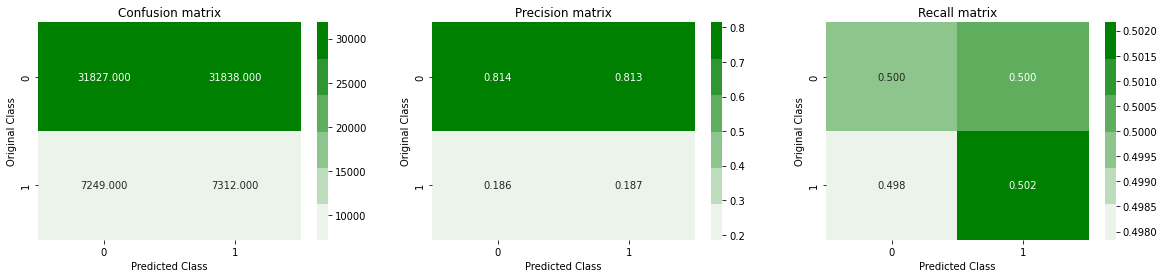

In [27]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

***Observation:*** In the Random Model, Precision is 0.187 and Recall is 0.5.

---

**23. Logistic Regression with hyperparameter tuning**

For values of alpha =  1e-05 The log loss is: 0.480590304089921
For values of alpha =  0.0001 The log loss is: 0.480590304089921
For values of alpha =  0.001 The log loss is: 0.4629161506855176
For values of alpha =  0.01 The log loss is: 0.4658764037343457
For values of alpha =  0.1 The log loss is: 0.4513916438677134
For values of alpha =  1 The log loss is: 0.4535593346033601
For values of alpha =  10 The log loss is: 0.46566497444870225


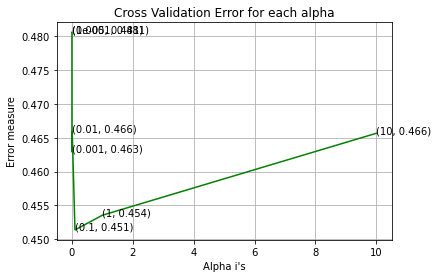

For values of best alpha =  0.1 The train log loss is: 0.4536234462606898
For values of best alpha =  0.1 The test log loss is: 0.4513916438677134
Total number of data points : 78226


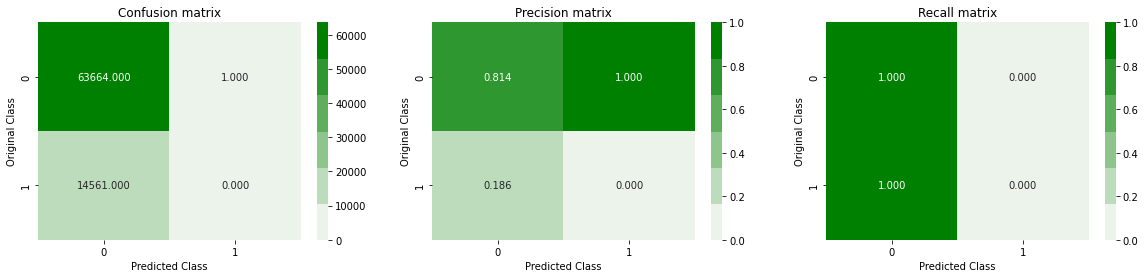

In [28]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

***Observation:*** The best hyper-parameter is 0.1 which has a log loss of 0.45 in both train and test. The Precision and Recall is not good when using Logistic Regression

---

**21. Random Forest Classifier**

X_train: (166881, 403)
Y_train: (166881,)
X_cv: (41721, 403)
y_cv: (41721,)
X_test: (52151, 403)
y_test: (52151,)


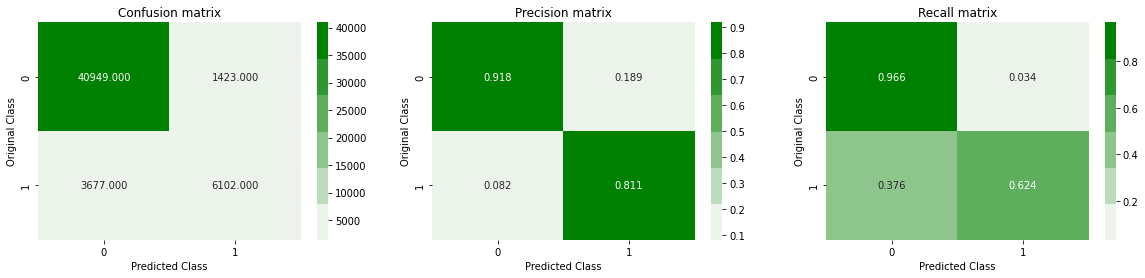

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(X_train_df, Y_train_df, stratify=Y_train_df, test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.20)

print('X_train: {0}'.format(X_train.shape))
print('Y_train: {0}'.format(y_train.shape))
print('X_cv: {0}'.format(X_cv.shape))
print('y_cv: {0}'.format(y_cv.shape))
print('X_test: {0}'.format(X_test.shape))
print('y_test: {0}'.format(y_test.shape))

r_cfl=RandomForestClassifier(random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf_rf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf_rf.fit(X_train, y_train)

predict_y = sig_clf_rf.predict_proba(X_train)
predict_y = sig_clf_rf.predict_proba(X_cv)
predict_y = sig_clf_rf.predict_proba(X_test)
plot_confusion_matrix(y_test, sig_clf_rf.predict(X_test))

***Observation:*** For RandomForest, the train and test is split in the ratio of 80:20.
RandomForest has a Precision of 0.811 and a Recall of 0.624.

---

**22. Ensemble Model**

**22.a Stacking Classifier**

Log loss (train) on the stacking classifier : 0.0008406150853672358
Log loss (CV) on the stacking classifier : 0.43460570152791933
Log loss (test) on the stacking classifier : 0.4341493901388488
Number of missclassified point : 0.09785047266591244


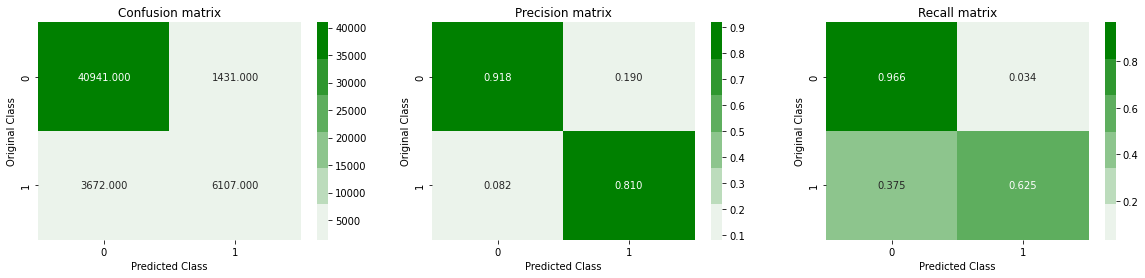

In [36]:
from sklearn.linear_model import LogisticRegression
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier

lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf, sig_clf_rf], meta_classifier=lr, use_probas=True)
sclf.fit(X_train, y_train)

log_error = log_loss(y_train, sclf.predict_proba(X_train))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(y_cv, sclf.predict_proba(X_cv))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(y_test, sclf.predict_proba(X_test))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(X_test)- y_test))/y_test.shape[0])
plot_confusion_matrix(test_y=y_test, predict_y=sclf.predict(X_test))

***Observation:*** When using Stacking Classifier, the number of misclassified points is 0.0978.
The Precision is 0.810 and the Recall is 0.625.

---

**22.a. Voting Classifier**

Log loss (train) on the VotingClassifier : 0.05065452059108677
Log loss (CV) on the VotingClassifier : 0.23445907620907874
Log loss (test) on the VotingClassifier : 0.23407272766224943
Number of missclassified point : 0.09779294740273436


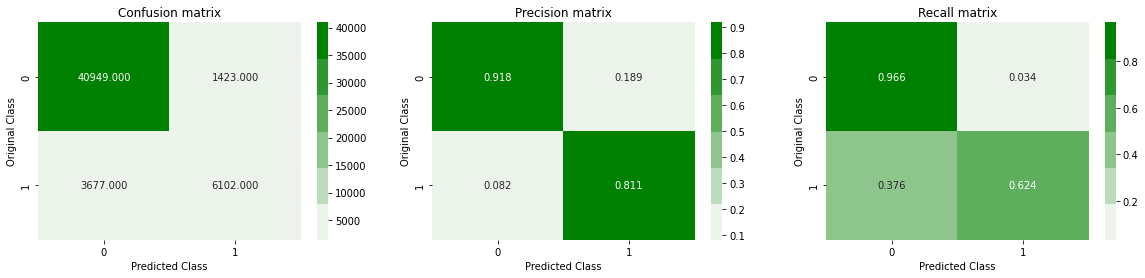

In [37]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf), ('rf', sig_clf_rf)], voting='soft')
vclf.fit(X_train, y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(y_train, vclf.predict_proba(X_train)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_cv, vclf.predict_proba(X_cv)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(X_test)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(X_test)- y_test))/y_test.shape[0])
plot_confusion_matrix(test_y=y_test, predict_y=vclf.predict(X_test))

***Observation:*** The Voting Classifier has a number of misclassified points of 0.0977.
The Precision is 0.811 and the Recall is 0.624.

---

***Conclusion:*** Hence, RandomForest is the best model for the given quoted insurance prediction problem which has less log loss and has the best Precision and Recall.

---